# Data

## AWID3 Dataset

AWID3 dataset consists of 13 captures of traffic in a wireless network. Of these 7 that focus on attacks on IEEE 802.11 MAC layer. The attacks chosen are: 

* Deauth
* Disass
* (Re)Assoc
* RogueAP
* Krack
* Kr00k
* Evil Twin

## Data preprocessing

For training of the model 

Features selection was based on [Pick Quality Over Quantity: Expert Feature Selection and Data Preprocessing for 802.11 Intrusion Detection Systems](https://ieeexplore.ieee.org/document/9797689) by the authors of the AWID3 dataset:

### Features chosen by Chatzoglou et. al. and their preprocessing

| Feature                    | Preprocessing    |
|----------------------------|------------------|
| frame.len                  | Min-Max Scaling  |
| radiotap.len               | Min-Max Scaling  |
| radiotap.dbm_antsignal     | Min-Max Scaling  |
| wlan.duration              | Min-Max Scaling  |
| radiotap.present.tsft      | One Hot Encoding |
| radiotap.channel.freq      | One Hot Encoding |
| radiotap.channel.type.cck  | One Hot Encoding |
| radiotap.channel.type.ofdm | One Hot Encoding |
| wlan.fc.type               | One Hot Encoding |
| wlan.fc.subtype            | One Hot Encoding |
| wlan.fc.ds                 | One Hot Encoding |
| wlan.fc.frag               | One Hot Encoding |
| wlan.fc.retry              | One Hot Encoding |
| wlan.fc.pwrmgt             | One Hot Encoding |
| wlan.fc.moredata           | One Hot Encoding |
| wlan.fc.protected          | One Hot Encoding |

The chosen features were prepocessed with following differences:
* frame.delta_time was was was added, as it is crucial for analyzing temproal patterns.
* features expressed by 0/1 values, such as IEEE 802.11 Frame Control flags were left unchanged (e.g. frag, retry), not One Hot Encoded as in above mentioned article.
* the authors  One Hot Encoding of channel frequencies, however such approach is only feasable, when there rather few categories (3 frequencies were used in the above mentioned files), so a more genral method of preprocessing frequncy is proposed:
    * create two binary features `2ghz_spectrum` and `5ghz_spectrum` to indicate in which band a frame was sent
    * apply Min-Max Scaling to frequency, using the highest and the lowest channel frequency in given band as Min and Max values, as seen below

In [1]:
def preporcess_frequency(radiotap_channel_freq):
    lower_2ghz, higher_2ghz = 2412, 2472
    lower_5ghz, higher_5gzh = 5160, 5885
    
    if (lower_2ghz <= radiotap_channel_freq <= higher_2ghz):
        _2ghz_spectrum = 1
        _5gzh_spectrum = 0
        freq = (radiotap_channel_freq - lower_2ghz) / (higher_2ghz - lower_2ghz)
    elif (lower_5ghz <= radiotap_channel_freq <= higher_5ghz):
        _2ghz_spectrum = 0
        _5gzh_spectrum = 1
        freq = (radiotap_channel_freq - lower_5ghz) / (higher_5ghz - lower_5ghz)
    else:
        _2ghz_spectrum = 0
        _5gzh_spectrum = 0
        freq = -1
        
    return _2ghz_spectrum, _5gzh_spectrum, freq
     

### Features and used preprocessing

| Feature                   | Type        | Preprocessing       | Values                    | Description                                                                                                       |
|---------------------------|-------------|---------------------|---------------------------|-------------------------------------------------------------------------------------------------------------------|
| frame.len                 | numeric     | Min-Max Scaling     | from 70 to 3220           | Length of frame, in bytes                                                                                         |
| frame.time_delta          | numeric     | Min-Max Scaling     | from 0 to 0.001817        | Time interval since previous frame, in seconds                                                                    |
| radiotap.len              | numeric     | Min-Max Scaling     | from 48 to 64             | Length of Radiotap header, in bytes                                                                               |
| radiotap.dbm_antsignal    | numeric     | Min-Max Scaling     | form -255 to -78          | Strength of recieved signal, in dBm. In AWID3 CSV files the value was summarized for antennas, hence very low values |
| wlan.duration             | numeric     | Min-Max Scaling     | from 0 to 726             | Duration/Id field in IEEE 802.11 header                                                                           |
| wlan.fc.type              | categorical | One Hot Encoding    | 0, 1, 2                   | IEEE 802.11 frame type: Management, Control or Data                                                               |
| wlan.fc.subtype           | categorical | One Hot Encoding    | 0, 1, ... 14, 15          | IEEE 802.11 frame subtype                                                                                         |
| wlan.fc.ds                | categorical | One Hot Encoding    | 0, 1, 2, 3                | Indicates whete a frame was sent to (tods) or from (fromds) a Distribution System (ds), neither or both           |
| radiotap.present.tsft     | binary      | convert to 0,1      | '0-0-0', '1-0-0'          | Presence of TSFT (Time Synchroniztion Function) in Radiotap header                                                |
| radiotap.channel.type.cck | binary      | None                | 0, 1                      | Whether frame was sent using CCK (Complemantary Code Keying), used in IEEE 802.11b                                |
| radiotap.channel.type.ofdm | binary     | None                | 0, 1                      | Whether frame was sent using OFDM (Orthognal Frequency Division Multiplexing) modulation                          |
| wlan.fc.frag              | binary      | None                | 0, 1                      | Frame Control flag, indicates if the frame was fragmented                                                         |
| wlan.fc.retry             | binary      | None                | 0, 1                      | Frame Control flag, indicates if the frame is retransmission of a previous frame                                  |
| wlan.fc.pwrmgt            | binary      | None                | 0, 1                      | Frame Control flag, used when station enters power management state                                               |
| wlan.fc.moredata          | binary      | None                | 0, 1                      | Frame Control flag, indicates that AP has buffered for the station                                                |
| wlan.fc.protected         | binary      | None                | 0, 1                      | Frame Control flag, indicates that frame has been encrypted                                                       |
| 2ghz_spectrum             | binary      | None                | 0, 1                      | The channel the frame was sent in is in 2.4GHz band                                                               |
| 5ghz_spectrum             | binary      | None                | 0, 1                      | The channel the frame was sent in is in 5GHz band                                                                 |
| freq                      | numeric     | As described above  | from 0 to 1               | Frequency scaled for the band station works in                                                                    |
| Label                     | Categorical | Convert to 0, 1, 2  | 'Normal' and attacks      | Label of given to the frame                                                                                      | 

Minimal and maximal values for ranges were estimated accros all AWID3 files, IQR was used to exckude otliers, that were then clipped into range 0, 1.

The traffic was divided into 3 classes:

Classes:

| Class | name           | Attacks                                                               |
|-------|----------------|-----------------------------------------------------------------------|
| 0     | normal         |                                                                       |
| 1     | flooding       | Deauth, Disass, (Re)Assoc, Kr00k                                      |
| 2     | impersonation  | RogueAP, Krack, Evil Twin                                             |

Both binary, and multiclass classificators were trained and evaluated on the dataset.

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import numpy as np
tf.config.run_functions_eagerly(True)

tfrecords_dir='dataset/AWID3_tfrecords'
tfrecords_balanced_dir='dataset/AWID3_tfrecords_balanced'

sequence_length = 32
sequence_shift = 30
n_features = 39

from collections import defaultdict

In [3]:
import data_utils

files = os.listdir(tfrecords_dir)

train_ratio = 0.8
train_files, test_files = data_utils.train_test_split(files, train_ratio=train_ratio)
train_files, val_files = data_utils.train_test_split(train_files, train_ratio=train_ratio)

print("Training set:")
for t in train_files:
    print(t.split('.')[0], end=', ')

print("\nValidation set:")
for t in val_files:
    print(t.split('.')[0], end=', ')

print("\nTest set:")
for t in test_files:
    print(t.split('.')[0], end=', ')
    
train_seq_files = [os.path.join(tfrecords_dir, f) for f in train_files]
val_seq_files = [os.path.join(tfrecords_dir, f) for f in val_files]
test_seq_files = [os.path.join(tfrecords_dir, f) for f in test_files]
train_bal_files = [os.path.join(tfrecords_balanced_dir, f) for f in train_files]
val_bal_files = [os.path.join(tfrecords_balanced_dir, f) for f in val_files]
test_bal_files = [os.path.join(tfrecords_balanced_dir, f) for f in test_files]



Training set:
(Re)Assoc_27, Kr00k_32, Deauth_31, Evil_Twin_71, Kr00k_43, Krack_26, Kr00k_35, (Re)Assoc_32, (Re)Assoc_25, Evil_Twin_66, Kr00k_38, Evil_Twin_49, Kr00k_46, (Re)Assoc_28, (Re)Assoc_35, Evil_Twin_53, Disas_35, Evil_Twin_69, RogueAP_29, Krack_27, (Re)Assoc_34, Deauth_25, Evil_Twin_45, Evil_Twin_67, Disas_36, Evil_Twin_51, Evil_Twin_70, Disas_39, Evil_Twin_36, (Re)Assoc_24, Evil_Twin_72, RogueAP_27, Deauth_29, Kr00k_34, Kr00k_39, Deauth_32, Kr00k_31, Kr00k_47, Deauth_27, Disas_28, Evil_Twin_60, RogueAP_32, Deauth_21, Evil_Twin_74, Kr00k_53, RogueAP_24, Evil_Twin_58, RogueAP_33, RogueAP_38, RogueAP_30, Evil_Twin_32, Disas_40, RogueAP_34, (Re)Assoc_31, Disas_31, Disas_29, Kr00k_42, RogueAP_37, Evil_Twin_59, Evil_Twin_65, (Re)Assoc_23, Kr00k_37, Evil_Twin_64, Disas_37, Evil_Twin_41, (Re)Assoc_26, Evil_Twin_57, Kr00k_52, Deauth_24, Evil_Twin_62, (Re)Assoc_22, Evil_Twin_52, Kr00k_57, Evil_Twin_46, Kr00k_33, Kr00k_48, Evil_Twin_33, Disas_38, Deauth_23, Evil_Twin_39, Kr00k_44, Evil_T

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score
import seaborn as sns

# functions for plotting and confusion matrix

def score_and_confusion_matrix(y_pred, y_true, title : str, binary = True, average='binary'):
    class_names = [
        'Normal', 'Attack'
    ] if binary else [
        'Normal', 'Flooding', 'Impersonation'
    ]
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    f1 = f1_score(y_true, y_pred, average=average)
    kappa = cohen_kappa_score(y_true, y_pred)
    print(f'Accuracy: {100*accuracy:2.3f}%')
    print(f'Precision: {100*precision:2.3f}%')
    print(f'Recall: {100*recall:2.3f}%')
    print(f'F1 : {f1:.4f}')
    print(f'Kappa: {kappa:.4f}')
    
    conf_matrix = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix: ' + title)
    plt.show()
    
    return accuracy, precision, recall, f1, kappa
    
def plot_model_history(history, title):
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(title)
    
    if 'accuracy' in history:
        axes[0, 0].plot(history['accuracy'], label='Train Accuracy')
        if 'val_accuracy' in history:
            axes[0, 0].plot(history['val_accuracy'], label='Val Accuracy')
        axes[0, 0].set_title('Accuracy')
        axes[0, 0].set_xlabel('Epochs')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].legend()
    
    # Plot Precision
    if 'precision' in history:
        axes[0, 1].plot(history['precision'], label='Train Precision')
        if 'val_precision' in history:
            axes[0, 1].plot(history['val_precision'], label='Val Precision')
        axes[0, 1].set_title('Precision')
        axes[0, 1].set_xlabel('Epochs')
        axes[0, 1].set_ylabel('Precision')
        axes[0, 1].legend()
    
    if 'recall' in history:
        axes[1, 0].plot(history['recall'], label='Train Recall')
        if 'val_recall' in history:
            axes[1, 0].plot(history['val_recall'], label='Val Recall')
        axes[1, 0].set_title('Recall')
        axes[1, 0].set_xlabel('Epochs')
        axes[1, 0].set_ylabel('Recall')
        axes[1, 0].legend()
    
    if 'loss' in history:
        axes[1, 1].plot(history['loss'], label='Train Loss')
        if 'val_loss' in history:
            axes[1, 1].plot(history['val_loss'], label='Val Loss')
        axes[1, 1].set_title('Loss')
        axes[1, 1].set_xlabel('Epochs')
        axes[1, 1].set_ylabel('Loss')
        axes[1, 1].legend()    
    plt.tight_layout()
    plt.show()
        

In [106]:
import binary_cnn_lstm
import data_utils

bin_cnn_lstm_model = binary_cnn_lstm.binary_CNN_LSTM_model()

if not bin_cnn_lstm_model.built:
    dataset_lambda = lambda x: data_utils.create_binary_sequential_dataset(x)
    histories = data_utils.step_training(
        train_seq_files,
        val_seq_files,
        bin_cnn_lstm_model,
        dataset_lambda,
        epochs_per_step=4,
        training_callbacks=[binary_cnn_lstm.checkpoint_callback],
        n_initial_files = 5,
        increment = 0.5
        
    )
    history = defaultdict(list)
    for h in histories:
        for metric, values in h.items():
            history[metric].extend(values) 
    
    plot_model_history(history, "Binary CNN-LSTM")
    print(history)
    #loading best checkpoint
    bin_cnn_lstm_model = binary_cnn_lstm.binary_CNN_LSTM_model()
    
bin_cnn_lstm_model.name = 'bin_CNN_LSTM'    
bin_cnn_lstm_model.summary()


Model loaded from saved_models/binary_cnn_lstm.keras


Model: "bin_CNN_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, None, 128)      │        25,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 128)      │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, None, 128)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, None, 64)       │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, None, 64)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, None, 32)       │         2,080 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, None, 32)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, None, 1)        │            33 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 624,581 (2.38 MB)

 Trainable params: 208,193 (813.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 416,388 (1.59 MB)

726/726 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step
Accuracy: 98.211%
Precision: 90.863%
Recall: 92.601%
F1 : 0.9172
Kappa: 0.9072


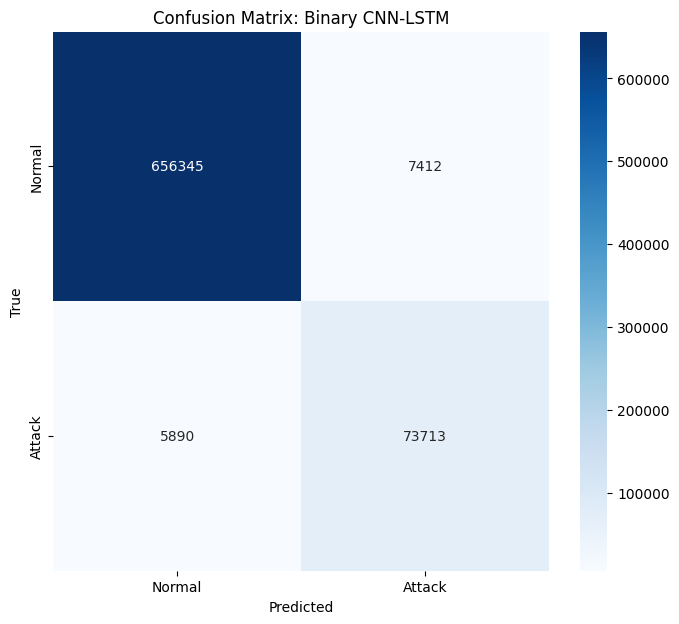

In [109]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_cnn_lstm_model.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
bin_cnn_lstm_metrics = score_and_confusion_matrix(y_pred, y_true, "Binary CNN-LSTM")


In [100]:
import binary_td_cnn
import data_utils

bin_td_cnn_model = binary_td_cnn.binary_time_domain_CNN_model()

if not bin_td_cnn_model.built:
    dataset_lambda = lambda x: data_utils.create_binary_sequential_dataset(x)
    histories = data_utils.step_training(
        train_seq_files,
        val_seq_files,
        bin_td_cnn_model,
        dataset_lambda,
        epochs_per_step=3,
        training_callbacks=[binary_td_cnn.checkpoint_callback],
        n_initial_files = 10,
        increment = 0.5
        
    )
    history = {}
    for h in histories:
        for metric, values in h.items():
            if not history[metric]:
                history[metric] = values
            else:
                history[metric].extend[values] 
    
    plot_model_history(history, "Binary Time Domain CNN")
    #loading best checkpoint
    bin_td_cnn_model = binary_td_cnn.binary_time_domain_CNN_model()
    
bin_td_cnn_model.name = 'bin_TD_CNN'    
bin_td_cnn_model.summary()

Model loaded from saved_models/binary_td_cnn.keras


Model: "bin_TD_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, None, 128)      │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, None, 64)       │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, None, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, None, 32)       │        10,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, None, 32)       │         1,056 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, None, 1)        │            33 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,365 (481.90 KB)

 Trainable params: 41,121 (160.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 82,244 (321.27 KB)

726/726 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
Accuracy: 98.652%
Precision: 92.117%
Recall: 95.591%
F1 : 0.9382
Kappa: 0.9307


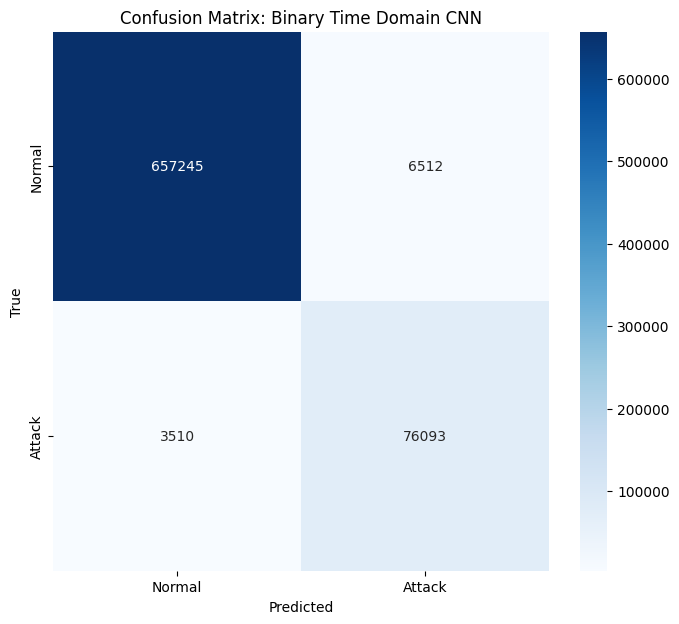

In [101]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_td_cnn_model.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
bin_td_cnn_metrics = score_and_confusion_matrix(y_pred, y_true, "Binary Time Domain CNN")


In [ ]:
import binary_cnn_gru
import data_utils

bin_cnn_gru_model = binary_cnn_gru.binary_CNN_GRU_model() 

if not bin_cnn_gru_model.built:
    dataset_lambda = lambda x: data_utils.create_binary_sequential_dataset(x)
    histories = data_utils.step_training(
        train_seq_files,
        val_seq_files,
        bin_td_cnn_model,
        dataset_lambda,
        epochs_per_step=3,
        training_callbacks=[bin_cnn_gru_model.checkpoint_callback],
        n_initial_files = 10,
        increment = 0.5
        
    )
    history = {}
    for h in histories:
        for metric, values in h.items():
            if not history[metric]:
                history[metric] = values
            else:
                history[metric].extend[values] 
    
    plot_model_history(history, "Binary CNN")
    #loading best checkpoint
    bin_cnn_gru_model = binary_cnn_gru.binary_CNN_GRU_model()
    
    
bin_cnn_gru_model.summary()
bin_cnn_gru_model.name = 'binary_CNN_GRU'

Model loaded from saved_models/binary_cnn_gru.keras


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, None, 64)       │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, None, 32)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, None, 48)       │        11,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, None, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, None, 32)       │         1,568 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, None, 1)        │            33 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,149 (211.52 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 36,100 (141.02 KB)

726/726 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step
Accuracy: 99.158%
Precision: 92.830%
Recall: 99.845%
F1 : 0.9621
Kappa: 0.9574


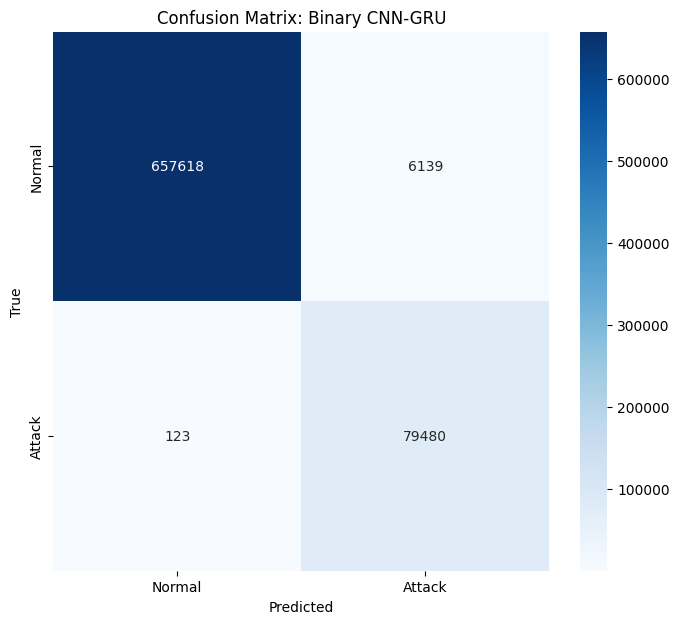

In [111]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_cnn_gru_model.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
bin_cnn_gru_metrics = score_and_confusion_matrix(y_pred, y_true, "Binary CNN-GRU")


In [6]:
import binary_cnn1d
import data_utils

bin_cnn1d_model = binary_cnn1d.binary_CNN1D_model()

if not bin_cnn1d_model.built:
    bin_bal_train_ds = data_utils.create_binary_dataset(train_bal_files)
    bin_bal_val_ds = data_utils.create_binary_dataset(val_bal_files)
    history = bin_cnn1d_model.fit(
            bin_bal_train_ds,
            validation_data = bin_bal_val_ds,
            epochs=30,
            callbacks = [binary_cnn1d.checkpoint_callback],
        )
    
    plot_model_history(history.history, 'Binary 1D-CNN')

bin_cnn1d_model.summary()




Model loaded from saved_models/binary_cnn1d.keras


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 1, 39)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1, 128)         │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1, 64)          │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 1, 32)          │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │         3,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,573 (220.99 KB)

 Trainable params: 18,857 (73.66 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 37,716 (147.33 KB)

53878/53878 ━━━━━━━━━━━━━━━━━━━━ 512s 10ms/step
Accuracy: 98.856%
Precision: 95.195%
Recall: 98.879%
F1 : 0.9700
Kappa: 0.9629


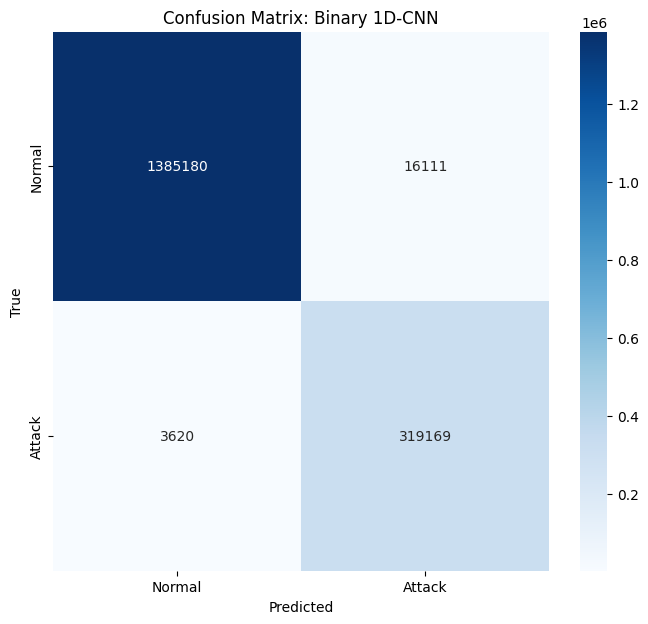

In [7]:
binary_bal_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files, batch=False)
features = []
labels = []

for x, y in binary_bal_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_cnn1d_model.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
bin_cnn1d_metrics = score_and_confusion_matrix(y_pred, y_true, 'Binary 1D-CNN')


In [8]:
import binary_dnn
import data_utils

bin_dnn_model = binary_dnn.binary_DNN_model()

if not bin_dnn_model.built:
    bin_bal_train_ds = data_utils.create_binary_dataset(train_bal_files)
    bin_bal_val_ds = data_utils.create_binary_dataset(val_bal_files)
    history = bin_dnn_model.fit(
            bin_bal_train_ds,
            validation_data = bin_bal_val_ds,
            epochs=30,
            callbacks = [binary_cnn1d.checkpoint_callback],
        )
    bin_dnn_model.summary()
    plot_model_history(history.history, 'Binary MLP')

     

Model loaded from saved_models/binary_dnn.keras


c:\Users\filip\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


53878/53878 ━━━━━━━━━━━━━━━━━━━━ 688s 13ms/step
Accuracy: 97.705%
Precision: 92.329%
Recall: 95.690%
F1 : 0.9398
Kappa: 0.9256


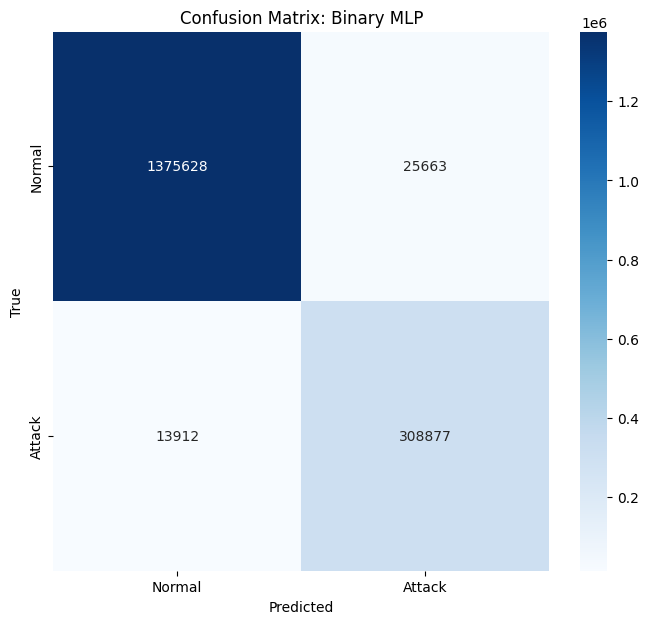

In [9]:
binary_bal_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files, batch=False)
features = []
labels = []

for x, y in binary_bal_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_dnn_model.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
bin_dnn_metrics = score_and_confusion_matrix(y_pred, y_true, 'Binary MLP')

## Results:

* CNN-LSTM
    * Accuracy: 98.211%
    * Precision: 90.863%
    * Recall: 92.601%
    * F1 : 0.9172
    * Kappa: 0.9072
* Time Domain CNN:
    * Accuracy: 98.652%
    * Precision: 92.117%
    * Recall: 95.591%
    * F1 : 0.9382
    * Kappa: 0.9307
* CNN-GRU
    * Accuracy: 99.158%
    * Precision: 92.830%
    * Recall: 99.845%
    * F1 : 0.9621
    * Kappa: 0.9574
* 1D-CNN
    * Accuracy: 99.226%
    * Precision: 92.984%
    * Recall: 99.891%
    * F1 : 0.9631
    * Kappa: 0.9588
* MLP
    * Accuracy: 99.196%
    * Precision: 93.115%
    * Recall: 99.872%
    * F1 : 0.9638
    * Kappa: 0.9592



In [112]:
from tensorflow.keras.layers import Input, Dense, TimeDistributed, Concatenate, Average

input_shape = (None, n_features)
input = Input(input_shape)

td_bin_cnn1d_model = TimeDistributed(bin_cnn1d_model)
td_bin_dnn_model = TimeDistributed(bin_dnn_model)

bin_base_classifiers = [
    bin_cnn_gru_model,
    td_bin_cnn1d_model,
    td_bin_dnn_model,
]

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = Average()(base_classifiers_outputs)

bin_arithmetic_mean_aggregate1 = tf.keras.Model(input, y)

metaclassifier_epochs = 3

bin_arithmetic_mean_aggregate1.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_arithmetic_mean_aggregate1.summary()

Model: "functional_218"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_27      │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ binary_CNN_GRU      │ (None, None, 1)   │     18,049 │ input_layer_27[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_57 │ (None, None, 1)   │      2,781 │ input_layer_27[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_58 │ (None, None, 1)   │      2,781 │ input_layer_27[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_7 (Average) │ (None, None, 1)   │          0 │ binary_CNN_GRU[0… │
│                     │                   │            │ time_distributed… │
│                     │                   │            │ time_distributed… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,611 (92.23 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,611 (92.23 KB)

726/726 ━━━━━━━━━━━━━━━━━━━━ 46s 20ms/step
Accuracy: 99.216%
Precision: 93.297%
Recall: 99.856%
F1 : 0.9646
Kappa: 0.9602


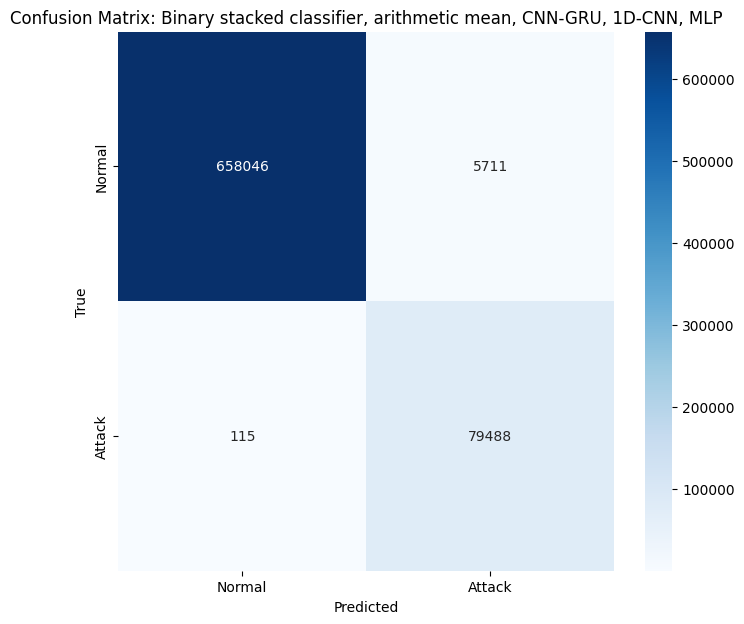

In [113]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_arithmetic_mean_aggregate1.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
bin_arithmentic_mean_score1 = score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, arithmetic mean, CNN-GRU, 1D-CNN, MLP')

In [114]:
import math
from tensorflow.keras.layers import Input, Dense, TimeDistributed, Concatenate, Lambda, Add

input_shape = (None, n_features)
input = Input(input_shape)

td_bin_cnn1d_model = TimeDistributed(bin_cnn1d_model)
td_bin_dnn_model = TimeDistributed(bin_dnn_model)

bin_base_classifiers = [
    bin_cnn_gru_model,
    td_bin_cnn1d_model,
    td_bin_dnn_model,
]

bin_f1_weights = [
    bin_cnn_gru_metrics[3],
    bin_cnn1d_metrics[3],
    bin_dnn_metrics[3],
]

bin_f1_weights = [math.log(w / (1 - w)) for w in bin_f1_weights]

sum_bin_f1_weights = sum(bin_f1_weights)

bin_f1_weights = tf.constant([w / sum_bin_f1_weights for w in bin_f1_weights], dtype=tf.float32)

print('F1 calculated_weights')
print(bin_f1_weights.numpy())

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = Lambda(lambda x: tf.multiply(x, bin_f1_weights), output_shape=(None, 3))(combined_output)
y = Lambda(lambda x: tf.reduce_sum(x, axis =-1), output_shape=(None, 3))(y)

bin_f1_weighted_aggregate1 = tf.keras.Model(input, y)


bin_f1_weighted_aggregate1.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_f1_weighted_aggregate1.summary()

F1 calculated_weights
[0.33076736 0.33372557 0.33550707]


Model: "functional_219"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_28      │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ binary_CNN_GRU      │ (None, None, 1)   │     18,049 │ input_layer_28[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_59 │ (None, None, 1)   │      2,781 │ input_layer_28[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_60 │ (None, None, 1)   │      2,781 │ input_layer_28[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_24      │ (None, None, 3)   │          0 │ binary_CNN_GRU[1… │
│ (Concatenate)       │                   │            │ time_distributed… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_17 (Lambda)  │ (None, None, 3)   │          0 │ concatenate_24[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_18 (Lambda)  │ (None, None, 3)   │          0 │ lambda_17[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,611 (92.23 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,611 (92.23 KB)

726/726 ━━━━━━━━━━━━━━━━━━━━ 27s 20ms/step
Accuracy: 99.216%
Precision: 93.297%
Recall: 99.856%
F1 : 0.9646
Kappa: 0.9602


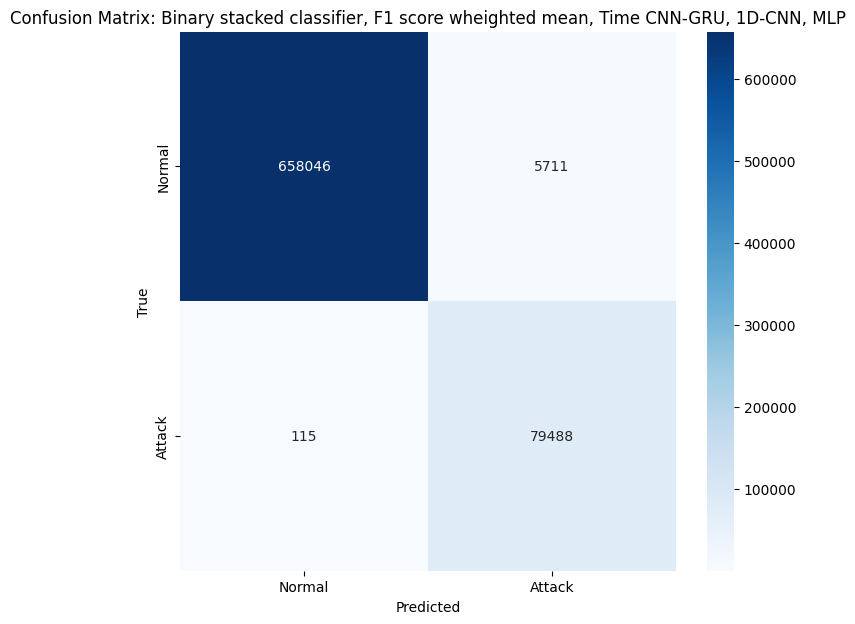

In [115]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_f1_weighted_aggregate1.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
bin_f1_weighted_score1 = score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, F1 score wheighted mean, Time CNN-GRU, 1D-CNN, MLP')

In [116]:
import math
from tensorflow.keras.layers import Input, Dense, TimeDistributed, Concatenate, Lambda, Add

input_shape = (None, n_features)
input = Input(input_shape)

td_bin_cnn1d_model = TimeDistributed(bin_cnn1d_model)
td_bin_dnn_model = TimeDistributed(bin_dnn_model)

bin_base_classifiers = [
    bin_cnn_gru_model,
    td_bin_cnn1d_model,
    td_bin_dnn_model,
]

bin_kappa_weights = [
    bin_cnn_gru_metrics[4],
    bin_cnn1d_metrics[4],
    bin_dnn_metrics[4],
]

bin_kappa_weights = [math.log((1 + w) / (1 - w)) for w in bin_kappa_weights]

sum_bin_kappa_weights = sum(bin_kappa_weights)

bin_kappa_weights = tf.constant([w / sum_bin_kappa_weights for w in bin_kappa_weights], dtype=tf.float32)

print('Kappa score calculated weights')
print(bin_kappa_weights.numpy())

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = Lambda(lambda x: tf.multiply(x, bin_kappa_weights), output_shape=(None, 3))(combined_output)
y = Lambda(lambda x: tf.reduce_sum(x, axis =-1), output_shape=(None, 3))(y)

bin_kappa_weighted_aggregate1 = tf.keras.Model(input, y)

metaclassifier_epochs = 3

bin_kappa_weighted_aggregate1.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_kappa_weighted_aggregate1.summary()

Kappa score calculated weights
[0.33099282 0.33405742 0.33494976]


Model: "functional_220"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_29      │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ binary_CNN_GRU      │ (None, None, 1)   │     18,049 │ input_layer_29[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_61 │ (None, None, 1)   │      2,781 │ input_layer_29[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_62 │ (None, None, 1)   │      2,781 │ input_layer_29[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_25      │ (None, None, 3)   │          0 │ binary_CNN_GRU[2… │
│ (Concatenate)       │                   │            │ time_distributed… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_19 (Lambda)  │ (None, None, 3)   │          0 │ concatenate_25[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_20 (Lambda)  │ (None, None, 3)   │          0 │ lambda_19[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,611 (92.23 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,611 (92.23 KB)

726/726 ━━━━━━━━━━━━━━━━━━━━ 36s 27ms/step
Accuracy: 99.216%
Precision: 93.297%
Recall: 99.856%
F1 : 0.9646
Kappa: 0.9602


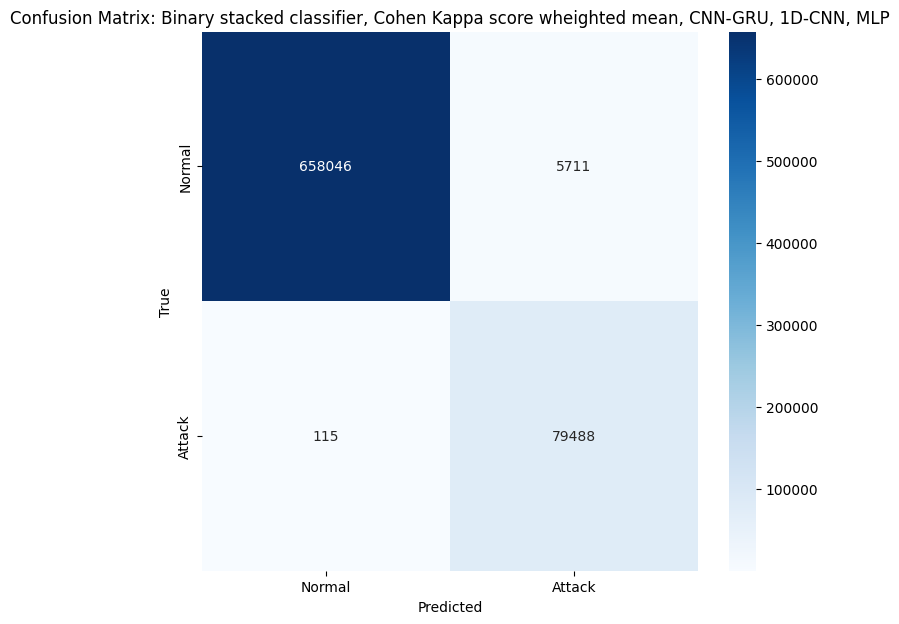

In [117]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_kappa_weighted_aggregate1.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
kappa_weighted_score1 = score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, Cohen Kappa score wheighted mean, CNN-GRU, 1D-CNN, MLP')

In [118]:
from tensorflow.keras.layers import Input, Dense, TimeDistributed, Concatenate, Reshape
input_shape = (None, n_features)
input = Input(input_shape)

td_bin_cnn1d_model = TimeDistributed(bin_cnn1d_model)
td_bin_dnn_model = TimeDistributed(bin_dnn_model)
reshaped_bin_td_cnn = Reshape((None, 1))(bin_td_cnn_model(input))
bin_base_classifiers = [
    bin_cnn_gru_model,
    td_bin_cnn1d_model,
    td_bin_dnn_model,
]

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [
    reshaped_bin_td_cnn,
    td_bin_cnn1d_model(input),
    td_bin_dnn_model(input)
]
combined_output = Concatenate()(base_classifiers_outputs)


y = TimeDistributed(Dense(1, activation='sigmoid', kernel_regularizer='l2'))(combined_output)


bin_stacked_log_regressor1 = tf.keras.Model(input, y)

metaclassifier_epochs = 3

bin_stacked_log_regressor1.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_stacked_log_regressor1.summary()

Model: "functional_221"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_30      │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bin_TD_CNN          │ (None, None, 1)   │     41,121 │ input_layer_30[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, None, 1)   │          0 │ bin_TD_CNN[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_63 │ (None, None, 1)   │      2,781 │ input_layer_30[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_64 │ (None, None, 1)   │      2,781 │ input_layer_30[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_26      │ (None, None, 3)   │          0 │ reshape_2[0][0],  │
│ (Concatenate)       │                   │            │ time_distributed… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_65 │ (None, None, 1)   │          4 │ concatenate_26[0… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 46,687 (182.37 KB)

 Trainable params: 41,125 (160.64 KB)

 Non-trainable params: 5,562 (21.73 KB)

Epoch 1/3
  18621/Unknown 133s 6ms/step - accuracy: 0.9135 - loss: 0.3399 - precision: 0.9572 - recall: 0.8310

c:\Users\filip\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


18625/18625 ━━━━━━━━━━━━━━━━━━━━ 160s 8ms/step - accuracy: 0.9136 - loss: 0.3399 - precision: 0.9572 - recall: 0.8310 - val_accuracy: 0.9989 - val_loss: 0.1660 - val_precision: 0.9979 - val_recall: 1.0000
Epoch 2/3
18625/18625 ━━━━━━━━━━━━━━━━━━━━ 180s 10ms/step - accuracy: 0.9986 - loss: 0.1657 - precision: 0.9978 - recall: 0.9995 - val_accuracy: 0.9989 - val_loss: 0.1646 - val_precision: 0.9979 - val_recall: 1.0000
Epoch 3/3
18625/18625 ━━━━━━━━━━━━━━━━━━━━ 143s 8ms/step - accuracy: 0.9987 - loss: 0.1658 - precision: 0.9978 - recall: 0.9996 - val_accuracy: 0.9990 - val_loss: 0.1647 - val_precision: 0.9990 - val_recall: 0.9990


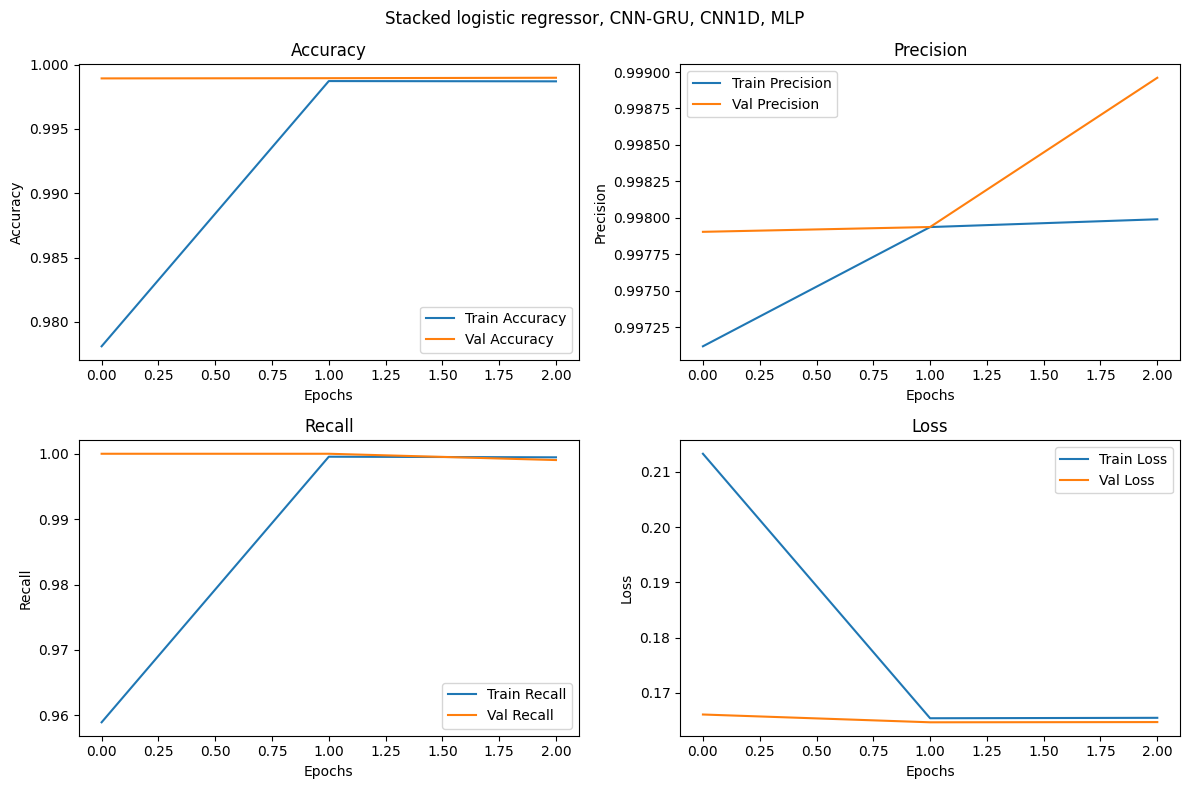

In [119]:
# creating sequences of length 1 from balanced dataset
train_bin_seq_ds = data_utils.create_binary_sequential_dataset(train_bal_files, filter_out_normal=False, seq_length=1, seq_shift=1)
val_bin_seq_ds = data_utils.create_binary_sequential_dataset(val_bal_files, filter_out_normal=False, seq_length=1, seq_shift=1)

history = bin_stacked_log_regressor1.fit(
    train_bin_seq_ds,
    validation_data = val_bin_seq_ds,
    epochs = metaclassifier_epochs,
)

plot_model_history(history.history, 'Stacked logistic regressor, CNN-GRU, CNN1D, MLP')

726/726 ━━━━━━━━━━━━━━━━━━━━ 29s 29ms/step
Accuracy: 99.155%
Precision: 92.801%
Recall: 99.856%
F1 : 0.9620
Kappa: 0.9572


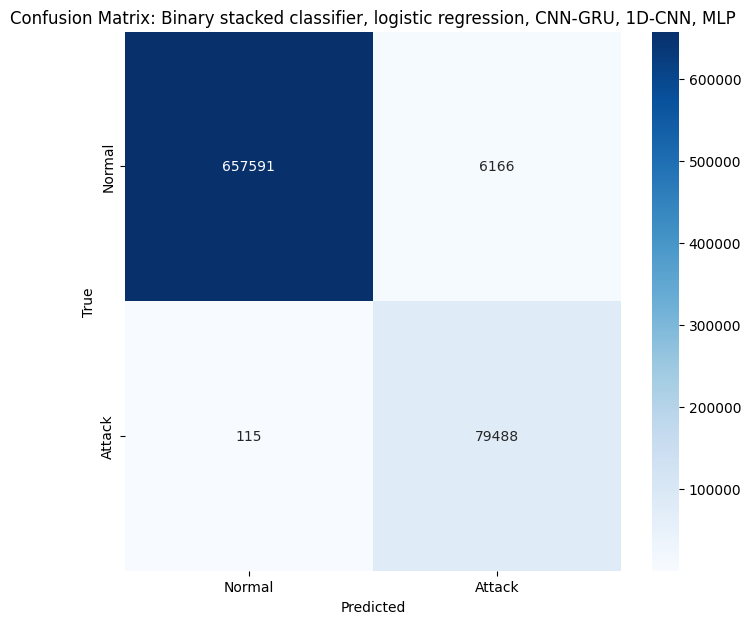

In [120]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_stacked_log_regressor1.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
bin_stacked_log_regressor1_metics = score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, logistic regression, CNN-GRU, 1D-CNN, MLP')

In [121]:
output_layer = bin_stacked_log_regressor1.layers[-1].layer.trainable_weights

output_weights = output_layer[0].numpy()
output_bias = output_layer[1].numpy()

print("Logistic regressor weights:\n", output_weights)
print("Logistic regressor bias: ", output_bias)

Logistic regressor weights:
 [[-1.7259493]
 [ 1.7225745]
 [ 1.7496715]]
Logistic regressor bias:  [-0.87612087]


In [122]:
import math
from tensorflow.keras.layers import Input, Dense, TimeDistributed, Concatenate, Lambda, Add

input_shape = (None, n_features)
input = Input(input_shape)

reshaped_bin_td_cnn = Reshape((None, 1))(bin_td_cnn_model(input))
td_bin_cnn1d_model = TimeDistributed(bin_cnn1d_model)
td_bin_dnn_model = TimeDistributed(bin_dnn_model)
reshaped_bin_td_cnn = Reshape((None, 1))(bin_td_cnn_model(input))
bin_base_classifiers = [
    bin_cnn_gru_model,
    td_bin_cnn1d_model,
    td_bin_dnn_model,
]

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [
    reshaped_bin_td_cnn,
    td_bin_cnn1d_model(input),
    td_bin_dnn_model(input)
]

bin_kappa_weights = [
    bin_cnn_gru_metrics[4],
    bin_cnn1d_metrics[4],
    bin_dnn_metrics[4],
]

sum_bin_kappa_weights = sum(bin_kappa_weights)

bin_kappa_weights = tf.constant([w / sum_bin_kappa_weights for w in bin_kappa_weights], dtype=tf.float32)

print(bin_kappa_weights)

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = Lambda(lambda x: tf.multiply(x, bin_kappa_weights), output_shape=(None, 3))(combined_output)
y = TimeDistributed(Dense(1, activation='sigmoid', kernel_regularizer='l2'))(y)

bin_kappa_weighted_regressor1 = tf.keras.Model(input, y)

metaclassifier_epochs = 3

bin_kappa_weighted_regressor1.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_kappa_weighted_regressor1.summary()

tf.Tensor([0.33294836 0.33345383 0.3335978 ], shape=(3,), dtype=float32)


Model: "functional_222"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_31      │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ binary_CNN_GRU      │ (None, None, 1)   │     18,049 │ input_layer_31[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_66 │ (None, None, 1)   │      2,781 │ input_layer_31[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_67 │ (None, None, 1)   │      2,781 │ input_layer_31[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_27      │ (None, None, 3)   │          0 │ binary_CNN_GRU[3… │
│ (Concatenate)       │                   │            │ time_distributed… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_21 (Lambda)  │ (None, None, 3)   │          0 │ concatenate_27[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_68 │ (None, None, 1)   │          4 │ lambda_21[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,615 (92.25 KB)

 Trainable params: 4 (16.00 B)

 Non-trainable params: 23,611 (92.23 KB)

Epoch 1/3
  18619/Unknown 100s 5ms/step - accuracy: 0.9988 - loss: 0.4775 - precision: 0.9981 - recall: 0.9994

c:\Users\filip\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


18625/18625 ━━━━━━━━━━━━━━━━━━━━ 127s 6ms/step - accuracy: 0.9988 - loss: 0.4775 - precision: 0.9981 - recall: 0.9994 - val_accuracy: 0.9992 - val_loss: 0.4423 - val_precision: 0.9994 - val_recall: 0.9989
Epoch 2/3
18625/18625 ━━━━━━━━━━━━━━━━━━━━ 118s 6ms/step - accuracy: 0.9991 - loss: 0.4457 - precision: 0.9988 - recall: 0.9994 - val_accuracy: 0.9992 - val_loss: 0.4423 - val_precision: 0.9994 - val_recall: 0.9989
Epoch 3/3
18625/18625 ━━━━━━━━━━━━━━━━━━━━ 140s 7ms/step - accuracy: 0.9990 - loss: 0.4457 - precision: 0.9989 - recall: 0.9991 - val_accuracy: 0.9992 - val_loss: 0.4424 - val_precision: 0.9994 - val_recall: 0.9989


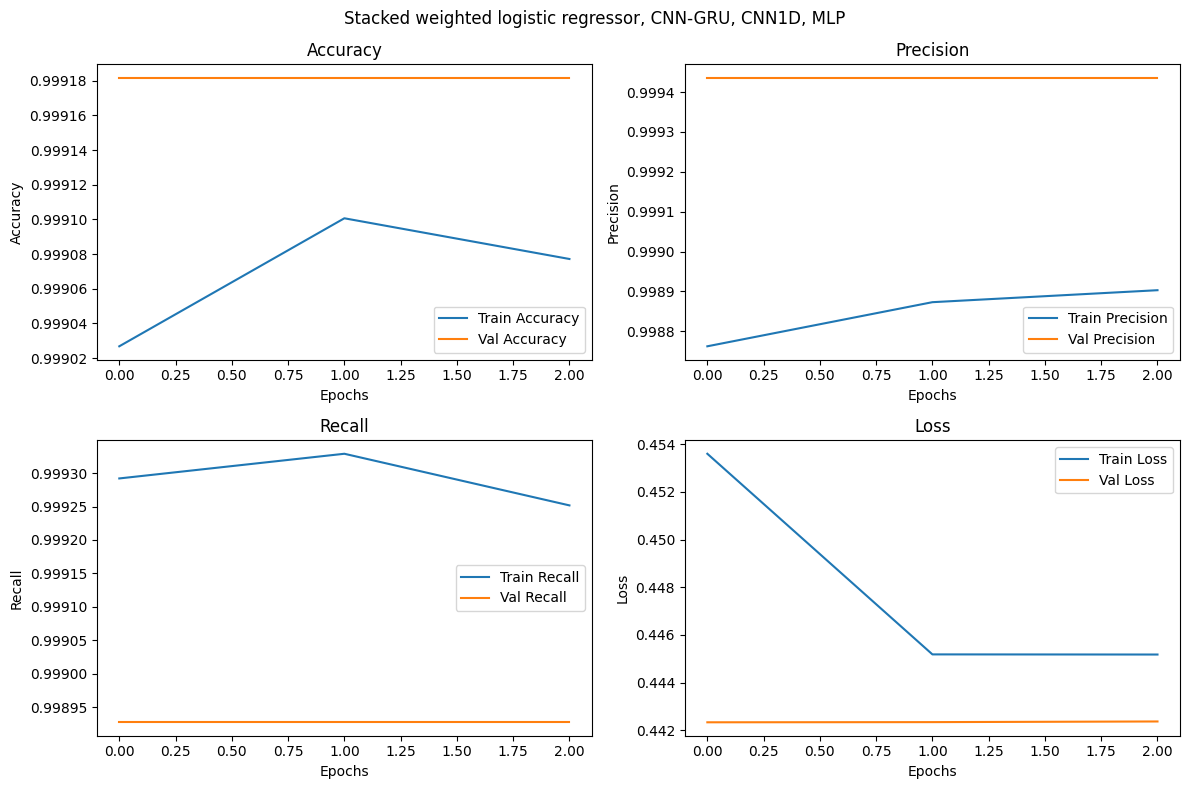

In [123]:
# creating sequences of length 1 from balanced dataset
train_bin_seq_ds = data_utils.create_binary_sequential_dataset(train_bal_files, filter_out_normal=False, seq_length=1, seq_shift=1)
val_bin_seq_ds = data_utils.create_binary_sequential_dataset(val_bal_files, filter_out_normal=False, seq_length=1, seq_shift=1)

history = bin_kappa_weighted_regressor1.fit(
    train_bin_seq_ds,
    validation_data = val_bin_seq_ds,
    epochs = metaclassifier_epochs,
)

plot_model_history(history.history, 'Stacked weighted logistic regressor, CNN-GRU, CNN1D, MLP')

726/726 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step
Accuracy: 99.217%
Precision: 93.299%
Recall: 99.856%
F1 : 0.9647
Kappa: 0.9603


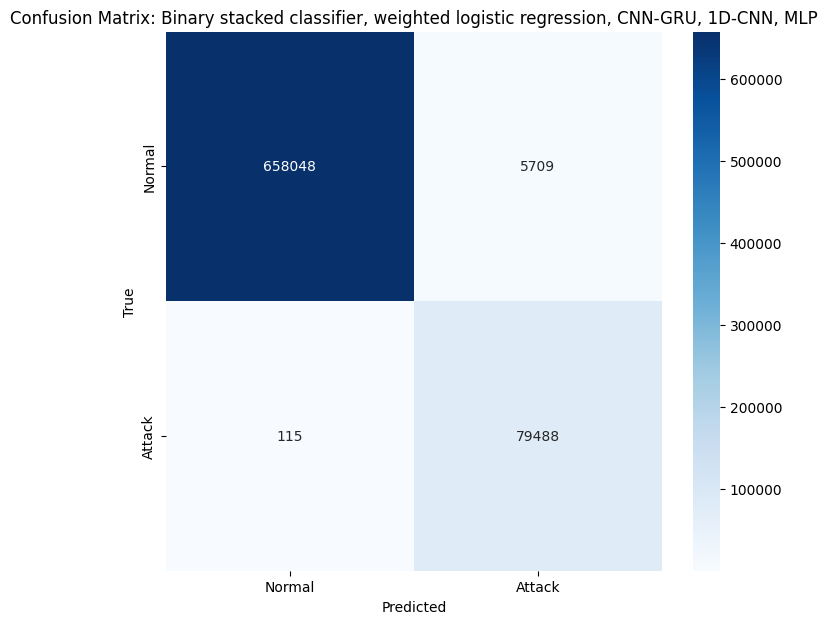

In [153]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_kappa_weighted_regressor1.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
bin_kappa_weighted_regressor1_metics = score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, weighted logistic regression, CNN-GRU, 1D-CNN, MLP')

In [154]:
output_layer = bin_kappa_weighted_regressor1.layers[-1].layer.trainable_weights

output_weights = output_layer[0].numpy()
output_bias = output_layer[1].numpy()

print("Logistic regressor weights:\n", output_weights)
print("Logistic regressor bias: ", output_bias)

Logistic regressor weights:
 [[1.9760517]
 [2.1745777]
 [2.1884952]]
Logistic regressor bias:  [-1.0572611]


In [124]:
from tensorflow.keras.layers import Input, Dense, TimeDistributed, Concatenate

input_shape = (None, n_features)
input = Input(input_shape)

td_bin_cnn1d_model = TimeDistributed(bin_cnn1d_model)
td_bin_dnn_model = TimeDistributed(bin_dnn_model)

bin_base_classifiers = [
    bin_cnn_gru_model,
    td_bin_cnn1d_model,
    td_bin_dnn_model,
]

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = TimeDistributed(Dense(4, activation='relu', kernel_regularizer='l2'))(combined_output)
y = TimeDistributed(Dense(4, activation='relu', kernel_regularizer='l2'))(y)
y = TimeDistributed(Dense(1, activation='sigmoid', kernel_regularizer='l2'))(y)


bin_stacked_dnn_classifier1 = tf.keras.Model(input, y)

metaclassifier_epochs = 4

bin_stacked_dnn_classifier1.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_stacked_dnn_classifier1.summary()

Model: "functional_223"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_32      │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ binary_CNN_GRU      │ (None, None, 1)   │     18,049 │ input_layer_32[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_69 │ (None, None, 1)   │      2,781 │ input_layer_32[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_70 │ (None, None, 1)   │      2,781 │ input_layer_32[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_28      │ (None, None, 3)   │          0 │ binary_CNN_GRU[4… │
│ (Concatenate)       │                   │            │ time_distributed… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_71 │ (None, None, 4)   │         16 │ concatenate_28[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_72 │ (None, None, 4)   │         20 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_73 │ (None, None, 1)   │          5 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,652 (92.39 KB)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 23,611 (92.23 KB)

Epoch 1/4
  18622/Unknown 120s 6ms/step - accuracy: 0.9680 - loss: 0.2216 - precision: 0.9711 - recall: 0.9630

c:\Users\filip\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


18625/18625 ━━━━━━━━━━━━━━━━━━━━ 154s 8ms/step - accuracy: 0.9680 - loss: 0.2216 - precision: 0.9711 - recall: 0.9630 - val_accuracy: 0.9992 - val_loss: 0.1056 - val_precision: 0.9994 - val_recall: 0.9989
Epoch 2/4
18625/18625 ━━━━━━━━━━━━━━━━━━━━ 136s 7ms/step - accuracy: 0.9991 - loss: 0.1069 - precision: 0.9988 - recall: 0.9993 - val_accuracy: 0.9992 - val_loss: 0.1055 - val_precision: 0.9994 - val_recall: 0.9989
Epoch 3/4
18625/18625 ━━━━━━━━━━━━━━━━━━━━ 143s 8ms/step - accuracy: 0.9992 - loss: 0.1069 - precision: 0.9988 - recall: 0.9995 - val_accuracy: 0.9992 - val_loss: 0.1055 - val_precision: 0.9994 - val_recall: 0.9989
Epoch 4/4
18625/18625 ━━━━━━━━━━━━━━━━━━━━ 120s 6ms/step - accuracy: 0.9992 - loss: 0.1069 - precision: 0.9989 - recall: 0.9994 - val_accuracy: 0.9992 - val_loss: 0.1054 - val_precision: 0.9994 - val_recall: 0.9989


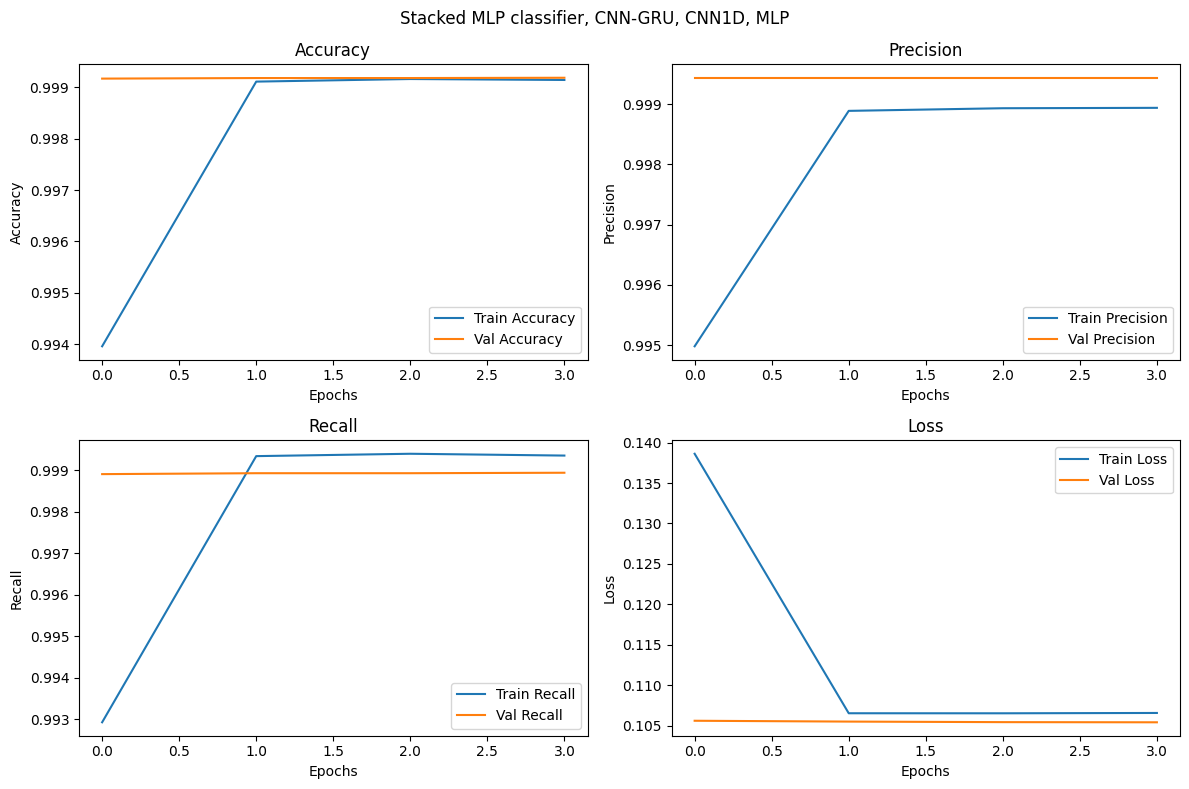

In [125]:
train_bin_seq_ds = data_utils.create_binary_sequential_dataset(train_bal_files, filter_out_normal=False, seq_length=1, seq_shift=1)
val_bin_seq_ds = data_utils.create_binary_sequential_dataset(val_bal_files, filter_out_normal=False, seq_length=1, seq_shift=1)

history = bin_stacked_dnn_classifier1.fit(
    train_bin_seq_ds,
    validation_data = val_bin_seq_ds,
    epochs = metaclassifier_epochs
)

plot_model_history(history.history, 'Stacked MLP classifier, CNN-GRU, CNN1D, MLP')

726/726 ━━━━━━━━━━━━━━━━━━━━ 44s 28ms/step
Accuracy: 99.216%
Precision: 93.294%
Recall: 99.856%
F1 : 0.9646
Kappa: 0.9602


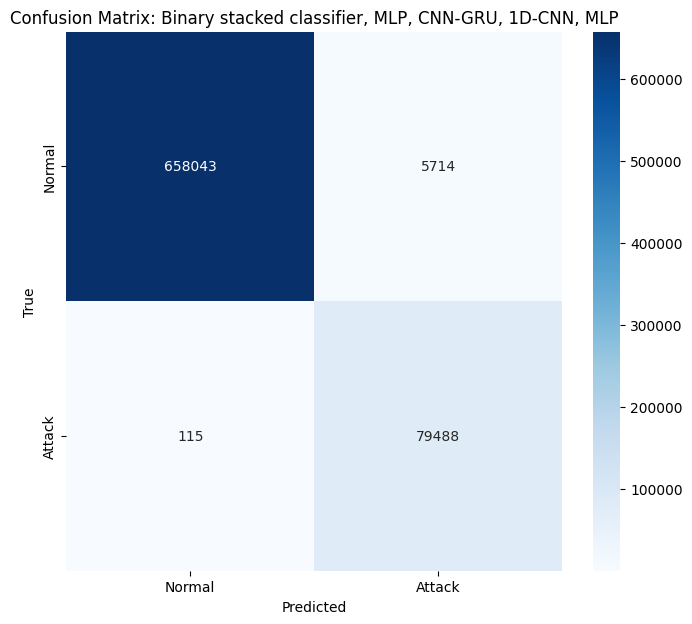

In [127]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_stacked_dnn_classifier1.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
bin_stacked_dnn_classifier_metrics = score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, MLP, CNN-GRU, 1D-CNN, MLP')

| Model                      | Accuracy | Precision | Recall  | F1       | Kappa   |
|----------------------------|----------|-----------|---------|----------|---------|
| CNN-GRU                    | 98.211%  | 92.830%   | 99.845% | 0.9621   | 0.95574 |
| 1D-CNN                     | 99.226%  | 92.984%   | 99.891% | 0.9631   | 0.9588  |
| MLP                        | 99.196%  | 93.115%   | 99.872% | 0.9638   | 0.9592  |
| Arithmetic mean            | 99.216%  | 93.297%   | 99.856% | 0.9646   | 0.9602  |
| Improvement from max       | -0.010%  |  0.182%   | -0.035% | 0.0018   | 0.0010  |
| F1 weighted mean           | 99.216%  | 93.297%   | 99.856% | 0.9646   | 0.9602  |
| Improvement from max       | -0.010%  |  0.182%   | -0.035% | 0.0018   | 0.0010  |
| Kappa weighted mean        | 99.216%  | 93.297%   | 99.856% | 0.9646   | 0.9602  |
| Improvement from max       | -0.010%  |  0.182%   | -0.035% | 0.0018   | 0.0010  |
| Logistic regression        | 99.155%  | 92.801%   | 99.856% | 0.9620   | 0.9572  |
| Improvement from max       | -0.071%  | -0.314%   | -0.035% | -0.0008  | -0.0020 |
| Kappa weighted log. reg.   | 99.217%  | 93.299%   | 99.856% | 0.9647   | 0.9603  |
| Improvement from max       | -0.009%  |  0.184%   | -0.035% | 0.0019   | -0.0020 |
| Stacked MLP                | 99.216%  | 93.294%   | 99.856% | 0.9646   | 0.9602  |
| Improvement from max       | -0.010%  |  0.179%   | -0.035% | 0.0018   | -0.0019 |




In [128]:
from keras.layers import Input, Dense, TimeDistributed, Concatenate, Average

input_shape = (None, n_features)
input = Input(input_shape)

bin_base_classifiers = [
    bin_cnn_lstm_model,
    bin_td_cnn_model,
    bin_cnn_gru_model,
]

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = Average()(base_classifiers_outputs)

bin_arithmetic_mean_aggregate2 = tf.keras.Model(input, y)

metaclassifier_epochs = 3

bin_arithmetic_mean_aggregate2.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall'],
)

bin_arithmetic_mean_aggregate2.summary()

Model: "functional_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_33      │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bin_CNN_LSTM        │ (None, None, 1)   │    208,193 │ input_layer_33[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bin_TD_CNN          │ (None, None, 1)   │     41,121 │ input_layer_33[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ binary_CNN_GRU      │ (None, None, 1)   │     18,049 │ input_layer_33[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_8 (Average) │ (None, None, 1)   │          0 │ bin_CNN_LSTM[0][… │
│                     │                   │            │ bin_TD_CNN[3][0], │
│                     │                   │            │ binary_CNN_GRU[5… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 267,363 (1.02 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 267,363 (1.02 MB)

726/726 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step
Accuracy: 98.256%
Precision: 91.973%
Recall: 91.723%
F1 : 0.9185
Kappa: 0.9087


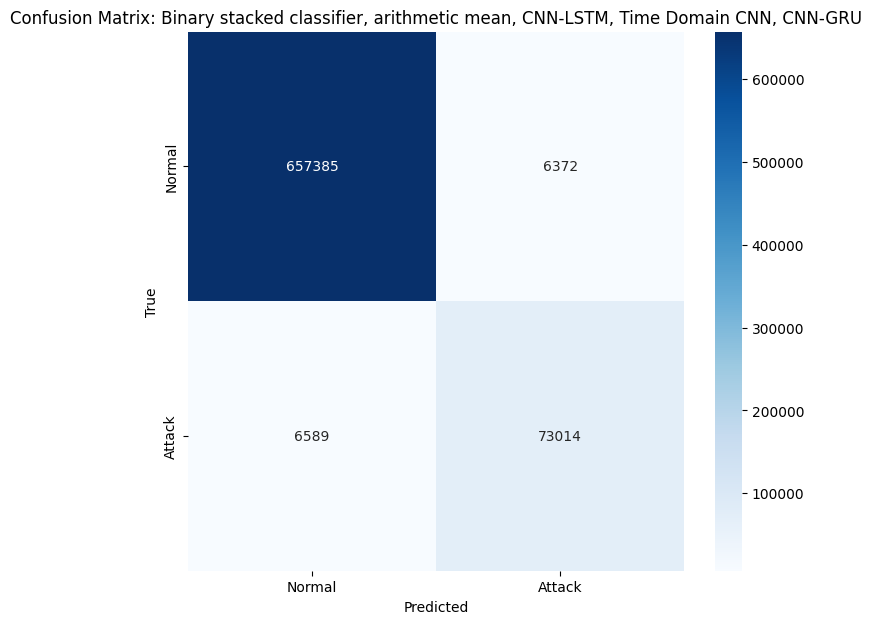

(0.9825643026259148,
 0.9197339581286373,
 0.9172267376857656,
 0.9184786368868286,
 0.9087168907470032)

In [129]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_arithmetic_mean_aggregate2.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, arithmetic mean, CNN-LSTM, Time Domain CNN, CNN-GRU')

In [130]:
import math
from keras.layers import Input, Dense, TimeDistributed, Concatenate, Lambda, Add

input_shape = (None, n_features)
input = Input(input_shape)

td_bin_dnn_model = TimeDistributed(bin_dnn_model)

bin_base_classifiers = [
    bin_cnn_lstm_model,
    bin_td_cnn_model,
    bin_cnn_gru_model,
]

bin_f1_weights = [
    bin_cnn_lstm_metrics[3],
    bin_td_cnn_metrics[3],
    bin_cnn_gru_metrics[3],
]

bin_f1_weights = [math.log(w / (1 - w)) for w in bin_f1_weights]

sum_bin_f1_weights = sum(bin_f1_weights)

bin_f1_weights = tf.constant([w / sum_bin_f1_weights for w in bin_f1_weights], dtype=tf.float32)

print(bin_f1_weights)

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = Lambda(lambda x: tf.multiply(x, bin_f1_weights), output_shape=(None, 3))(combined_output)
y = Lambda(lambda x: tf.reduce_sum(x, axis =-1), output_shape=(None, 3))(y)

bin_f1_weighted_aggregate2 = tf.keras.Model(input, y)


bin_f1_weighted_aggregate2.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_f1_weighted_aggregate2.summary()

tf.Tensor([0.28773263 0.32540166 0.3868657 ], shape=(3,), dtype=float32)


Model: "functional_225"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_34      │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bin_CNN_LSTM        │ (None, None, 1)   │    208,193 │ input_layer_34[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bin_TD_CNN          │ (None, None, 1)   │     41,121 │ input_layer_34[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ binary_CNN_GRU      │ (None, None, 1)   │     18,049 │ input_layer_34[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_30      │ (None, None, 3)   │          0 │ bin_CNN_LSTM[1][… │
│ (Concatenate)       │                   │            │ bin_TD_CNN[4][0], │
│                     │                   │            │ binary_CNN_GRU[6… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_22 (Lambda)  │ (None, None, 3)   │          0 │ concatenate_30[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_23 (Lambda)  │ (None, None, 3)   │          0 │ lambda_22[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 267,363 (1.02 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 267,363 (1.02 MB)

726/726 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step
Accuracy: 98.369%
Precision: 92.346%
Recall: 92.427%
F1 : 0.9239
Kappa: 0.9147


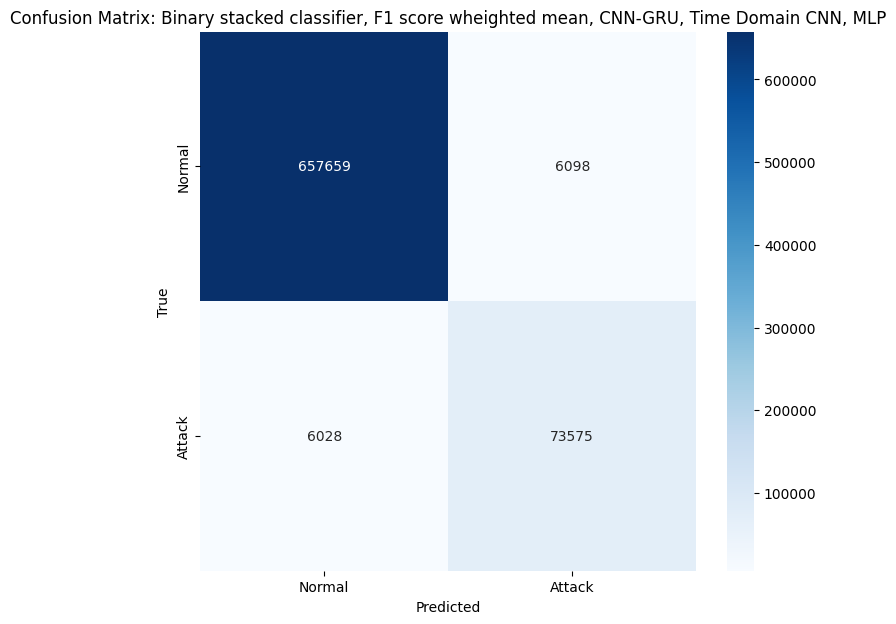

(0.9836875807145932,
 0.9234621515444379,
 0.9242742107709508,
 0.923868002712273,
 0.9147331560619939)

In [131]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_f1_weighted_aggregate2.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, F1 score wheighted mean, CNN-GRU, Time Domain CNN, MLP')

In [132]:
import math
from tensorflow.keras.layers import Input, Dense, TimeDistributed, Concatenate, Lambda, Add

input_shape = (None, n_features)
input = Input(input_shape)

bin_base_classifiers = [
    bin_cnn_lstm_model,
    bin_td_cnn_model,
    bin_cnn_gru_model,
]

bin_kappa_weights = [
    bin_cnn_lstm_metrics[4],
    bin_td_cnn_metrics[4],
    bin_cnn_gru_metrics[4],
]

bin_kappa_weights = [math.log((1 + w) / (1 - w)) for w in bin_kappa_weights]

sum_bin_kappa_weights = sum(bin_kappa_weights)

bin_kappa_weights = tf.constant([w / sum_bin_kappa_weights for w in bin_kappa_weights], dtype=tf.float32)

print(bin_kappa_weights)

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = Lambda(lambda x: tf.multiply(x, bin_kappa_weights), output_shape=(None, 3))(combined_output)
y = Lambda(lambda x: tf.reduce_sum(x, axis =-1), output_shape=(None, 3))(y)

bin_kappa_weighted_aggregate2 = tf.keras.Model(input, y)

metaclassifier_epochs = 3

bin_kappa_weighted_aggregate2.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_kappa_weighted_aggregate2.summary()

tf.Tensor([0.29706785 0.3268852  0.37604693], shape=(3,), dtype=float32)


Model: "functional_226"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_35      │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bin_CNN_LSTM        │ (None, None, 1)   │    208,193 │ input_layer_35[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bin_TD_CNN          │ (None, None, 1)   │     41,121 │ input_layer_35[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ binary_CNN_GRU      │ (None, None, 1)   │     18,049 │ input_layer_35[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_31      │ (None, None, 3)   │          0 │ bin_CNN_LSTM[2][… │
│ (Concatenate)       │                   │            │ bin_TD_CNN[5][0], │
│                     │                   │            │ binary_CNN_GRU[7… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_24 (Lambda)  │ (None, None, 3)   │          0 │ concatenate_31[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_25 (Lambda)  │ (None, None, 3)   │          0 │ lambda_24[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 267,363 (1.02 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 267,363 (1.02 MB)

726/726 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step
Accuracy: 98.345%
Precision: 92.272%
Recall: 92.277%
F1 : 0.9227
Kappa: 0.9135


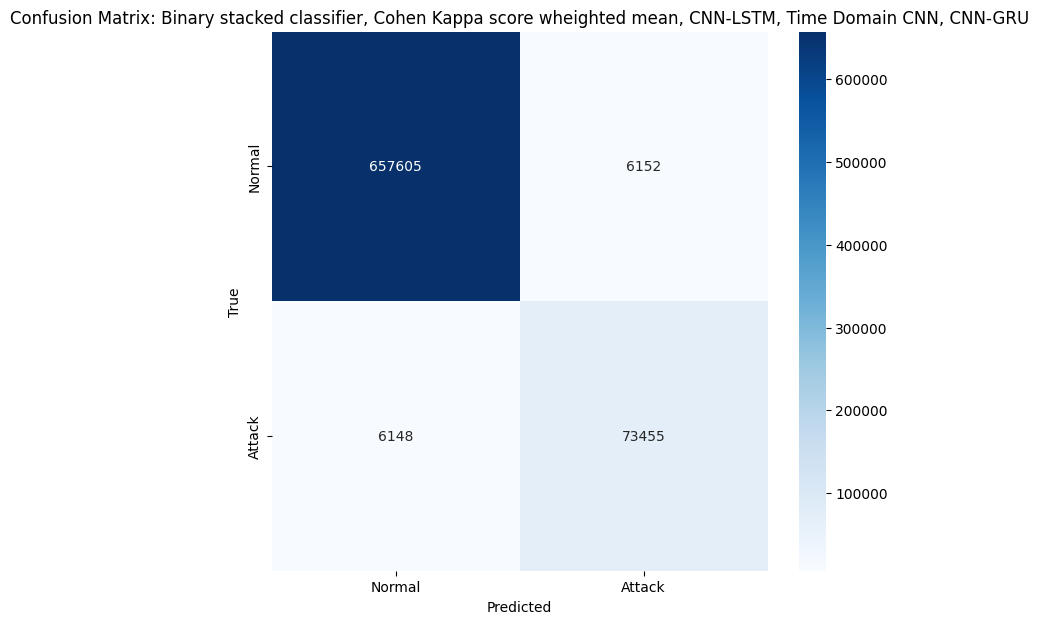

(0.9834535083943177,
 0.9227203637871042,
 0.9227667298971144,
 0.922743546259657,
 0.9134780793394042)

In [133]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_kappa_weighted_aggregate2.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, Cohen Kappa score wheighted mean, CNN-LSTM, Time Domain CNN, CNN-GRU')

In [134]:
from keras.layers import Input, Dense, TimeDistributed, Concatenate
input_shape = (None, n_features)
input = Input(input_shape)

bin_base_classifiers = [
    bin_cnn_lstm_model,
    bin_td_cnn_model,
    bin_cnn_gru_model,
]

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = TimeDistributed(Dense(1, activation='sigmoid', kernel_regularizer='l2'))(combined_output)


bin_stacked_log_regressor2 = tf.keras.Model(input, y)

metaclassifier_epochs = 3

bin_stacked_log_regressor2.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_stacked_log_regressor2.summary()

Model: "functional_227"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_36      │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bin_CNN_LSTM        │ (None, None, 1)   │    208,193 │ input_layer_36[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bin_TD_CNN          │ (None, None, 1)   │     41,121 │ input_layer_36[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ binary_CNN_GRU      │ (None, None, 1)   │     18,049 │ input_layer_36[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_32      │ (None, None, 3)   │          0 │ bin_CNN_LSTM[3][… │
│ (Concatenate)       │                   │            │ bin_TD_CNN[6][0], │
│                     │                   │            │ binary_CNN_GRU[8… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_75 │ (None, None, 1)   │          4 │ concatenate_32[0… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 267,367 (1.02 MB)

 Trainable params: 4 (16.00 B)

 Non-trainable params: 267,363 (1.02 MB)

Epoch 1/3
  18624/Unknown 109s 5ms/step - accuracy: 0.9925 - loss: 0.2562 - precision: 0.9958 - recall: 0.9889

c:\Users\filip\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


18625/18625 ━━━━━━━━━━━━━━━━━━━━ 137s 7ms/step - accuracy: 0.9925 - loss: 0.2562 - precision: 0.9958 - recall: 0.9889 - val_accuracy: 0.9979 - val_loss: 0.1770 - val_precision: 0.9968 - val_recall: 0.9990
Epoch 2/3
18625/18625 ━━━━━━━━━━━━━━━━━━━━ 130s 7ms/step - accuracy: 0.9984 - loss: 0.1784 - precision: 0.9971 - recall: 0.9997 - val_accuracy: 0.9979 - val_loss: 0.1770 - val_precision: 0.9968 - val_recall: 0.9990
Epoch 3/3
18625/18625 ━━━━━━━━━━━━━━━━━━━━ 133s 7ms/step - accuracy: 0.9984 - loss: 0.1783 - precision: 0.9972 - recall: 0.9996 - val_accuracy: 0.9979 - val_loss: 0.1770 - val_precision: 0.9968 - val_recall: 0.9990


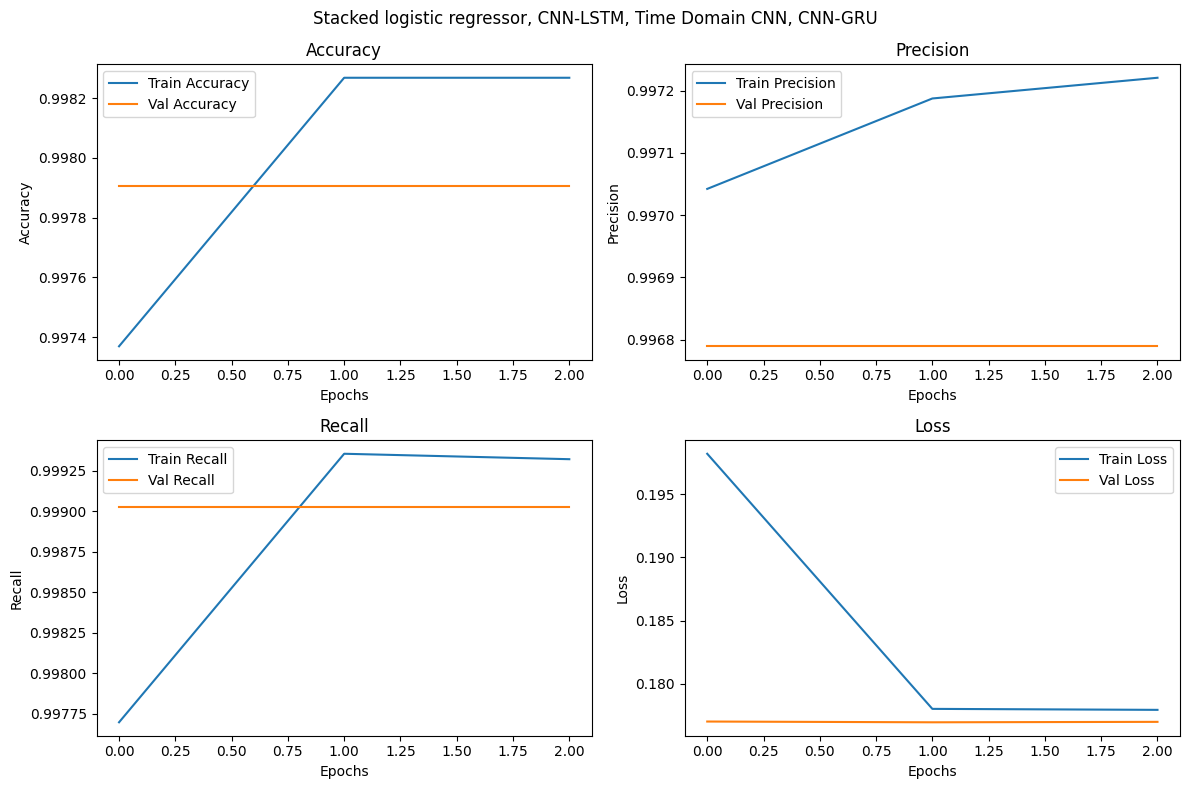

In [135]:
# creating sequences of length 1 from balanced dataset
train_bin_seq_ds = data_utils.create_binary_sequential_dataset(train_bal_files, filter_out_normal=False, seq_length=1, seq_shift=1)
val_bin_seq_ds = data_utils.create_binary_sequential_dataset(val_bal_files, filter_out_normal=False, seq_length=1, seq_shift=1)

history = bin_stacked_log_regressor2.fit(
    train_bin_seq_ds,
    validation_data = val_bin_seq_ds,
    epochs = metaclassifier_epochs,
)

plot_model_history(history.history, 'Stacked logistic regressor, CNN-LSTM, Time Domain CNN, CNN-GRU')

726/726 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step
Accuracy: 99.038%
Precision: 91.870%
Recall: 99.857%
F1 : 0.9570
Kappa: 0.9516


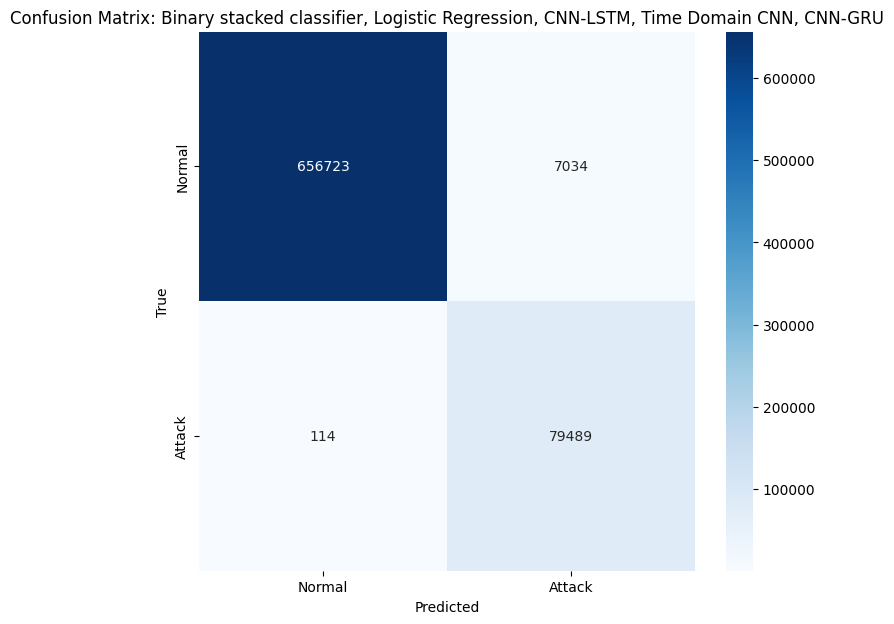

(0.9903842014636246,
 0.9187036972828034,
 0.9985678931698554,
 0.9569724185256974,
 0.9515702737619152)

In [136]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_stacked_log_regressor2.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, Logistic Regression, CNN-LSTM, Time Domain CNN, CNN-GRU')

In [137]:

from keras.layers import Input, Dense, TimeDistributed, Concatenate, Lambda, Add

input_shape = (None, n_features)
input = Input(input_shape)

td_bin_cnn1d_model = TimeDistributed(bin_cnn1d_model)
td_bin_dnn_model = TimeDistributed(bin_dnn_model)

bin_base_classifiers = [
    bin_cnn_lstm_model,
    bin_td_cnn_model,
    bin_cnn_gru_model,
]

bin_kappa_weights = [
    bin_cnn_lstm_metrics[4],
    bin_td_cnn_metrics[4],
    bin_cnn_gru_metrics[4],
]

sum_bin_kappa_weights = sum(bin_kappa_weights)

bin_kappa_weights = tf.constant([w / sum_bin_kappa_weights for w in bin_kappa_weights], dtype=tf.float32)

print(bin_kappa_weights)

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = Lambda(lambda x: tf.multiply(x, bin_kappa_weights), output_shape=(None, 3))(combined_output)
y = TimeDistributed(Dense(1, activation='sigmoid', kernel_regularizer='l2'))(y)

bin_kappa_weighted_regressor2 = tf.keras.Model(input, y)

metaclassifier_epochs = 3

bin_kappa_weighted_regressor2.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_kappa_weighted_regressor2.summary()

tf.Tensor([0.32455614 0.332943   0.3425009 ], shape=(3,), dtype=float32)


Model: "functional_228"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_37      │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bin_CNN_LSTM        │ (None, None, 1)   │    208,193 │ input_layer_37[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bin_TD_CNN          │ (None, None, 1)   │     41,121 │ input_layer_37[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ binary_CNN_GRU      │ (None, None, 1)   │     18,049 │ input_layer_37[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_33      │ (None, None, 3)   │          0 │ bin_CNN_LSTM[4][… │
│ (Concatenate)       │                   │            │ bin_TD_CNN[7][0], │
│                     │                   │            │ binary_CNN_GRU[9… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_26 (Lambda)  │ (None, None, 3)   │          0 │ concatenate_33[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_78 │ (None, None, 1)   │          4 │ lambda_26[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 267,367 (1.02 MB)

 Trainable params: 4 (16.00 B)

 Non-trainable params: 267,363 (1.02 MB)

Epoch 1/3
  18615/Unknown 98s 5ms/step - accuracy: 0.9983 - loss: 0.4802 - precision: 0.9969 - recall: 0.9997

c:\Users\filip\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


18625/18625 ━━━━━━━━━━━━━━━━━━━━ 123s 6ms/step - accuracy: 0.9983 - loss: 0.4802 - precision: 0.9969 - recall: 0.9997 - val_accuracy: 0.9979 - val_loss: 0.4498 - val_precision: 0.9968 - val_recall: 0.9990
Epoch 2/3
18625/18625 ━━━━━━━━━━━━━━━━━━━━ 114s 6ms/step - accuracy: 0.9984 - loss: 0.4522 - precision: 0.9972 - recall: 0.9996 - val_accuracy: 0.9979 - val_loss: 0.4498 - val_precision: 0.9968 - val_recall: 0.9990
Epoch 3/3
18625/18625 ━━━━━━━━━━━━━━━━━━━━ 126s 7ms/step - accuracy: 0.9984 - loss: 0.4522 - precision: 0.9972 - recall: 0.9997 - val_accuracy: 0.9979 - val_loss: 0.4499 - val_precision: 0.9968 - val_recall: 0.9990


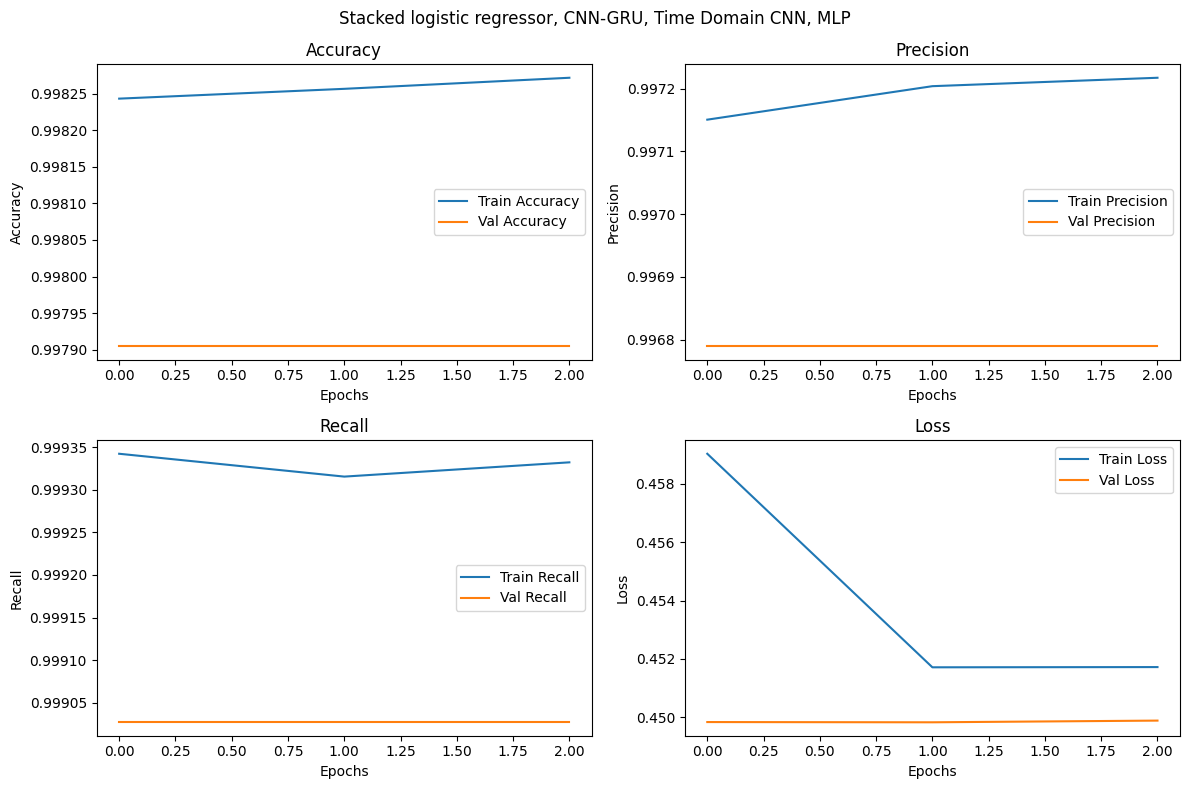

In [138]:
# creating sequences of length 1 from balanced dataset
train_bin_seq_ds = data_utils.create_binary_sequential_dataset(train_bal_files, filter_out_normal=False, seq_length=1, seq_shift=1)
val_bin_seq_ds = data_utils.create_binary_sequential_dataset(val_bal_files, filter_out_normal=False, seq_length=1, seq_shift=1)

history = bin_kappa_weighted_regressor2.fit(
    train_bin_seq_ds,
    validation_data = val_bin_seq_ds,
    epochs = metaclassifier_epochs,
)

plot_model_history(history.history, 'Stacked logistic regressor, CNN-GRU, Time Domain CNN, MLP')

726/726 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step
Accuracy: 99.039%
Precision: 91.876%
Recall: 99.857%
F1 : 0.9570
Kappa: 0.9516


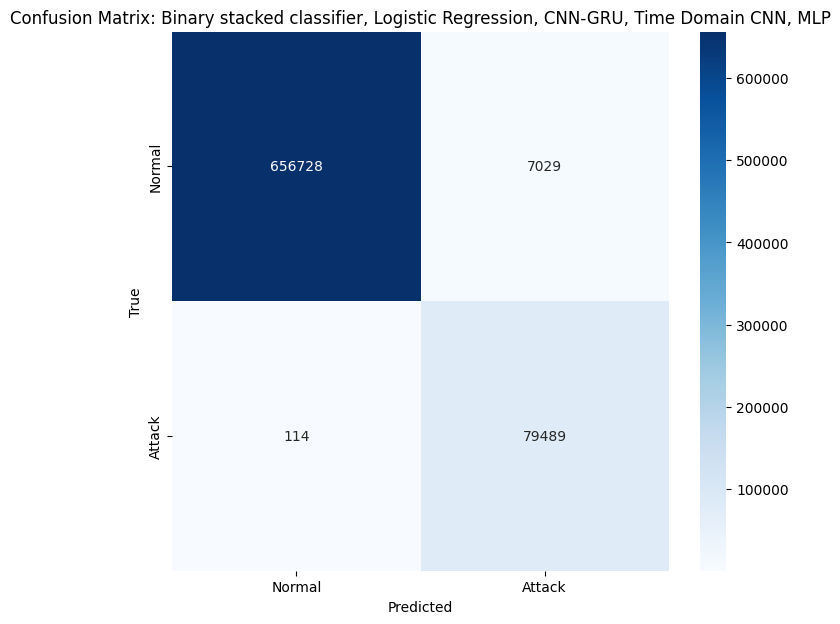

(0.9903909276797245,
 0.9187567904944636,
 0.9985678931698554,
 0.9570012220008307,
 0.9516028617952601)

In [ ]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_kappa_weighted_regressor2.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier,Kappa Weighted Logistic Regression, CNN-GRU, Time Domain CNN, MLP')

In [140]:
from keras.layers import Input, Dense, TimeDistributed, Concatenate

input_shape = (None, n_features)
input = Input(input_shape)

bin_base_classifiers = [
    bin_cnn_lstm_model,
    bin_td_cnn_model,
    bin_cnn_gru_model,
]

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = TimeDistributed(Dense(4, activation='relu', kernel_regularizer='l2'))(combined_output)
y = TimeDistributed(Dense(4, activation='relu', kernel_regularizer='l2'))(y)
y = TimeDistributed(Dense(1, activation='sigmoid', kernel_regularizer='l2'))(y)


bin_stacked_dnn_classifier2 = tf.keras.Model(input, y)

metaclassifier_epochs = 5

bin_stacked_dnn_classifier2.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_stacked_dnn_classifier2.summary()

Model: "functional_229"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_38      │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bin_CNN_LSTM        │ (None, None, 1)   │    208,193 │ input_layer_38[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bin_TD_CNN          │ (None, None, 1)   │     41,121 │ input_layer_38[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ binary_CNN_GRU      │ (None, None, 1)   │     18,049 │ input_layer_38[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_34      │ (None, None, 3)   │          0 │ bin_CNN_LSTM[5][… │
│ (Concatenate)       │                   │            │ bin_TD_CNN[8][0], │
│                     │                   │            │ binary_CNN_GRU[1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_79 │ (None, None, 4)   │         16 │ concatenate_34[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_80 │ (None, None, 4)   │         20 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_81 │ (None, None, 1)   │          5 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 267,404 (1.02 MB)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 267,363 (1.02 MB)

Epoch 1/5
  18622/Unknown 138s 6ms/step - accuracy: 0.9810 - loss: 0.2061 - precision: 0.9846 - recall: 0.9757

c:\Users\filip\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


18625/18625 ━━━━━━━━━━━━━━━━━━━━ 169s 8ms/step - accuracy: 0.9811 - loss: 0.2061 - precision: 0.9846 - recall: 0.9757 - val_accuracy: 0.9979 - val_loss: 0.1104 - val_precision: 0.9968 - val_recall: 0.9990
Epoch 2/5
18625/18625 ━━━━━━━━━━━━━━━━━━━━ 141s 8ms/step - accuracy: 0.9984 - loss: 0.1099 - precision: 0.9972 - recall: 0.9996 - val_accuracy: 0.9979 - val_loss: 0.1104 - val_precision: 0.9968 - val_recall: 0.9990
Epoch 3/5
18625/18625 ━━━━━━━━━━━━━━━━━━━━ 144s 8ms/step - accuracy: 0.9984 - loss: 0.1099 - precision: 0.9971 - recall: 0.9997 - val_accuracy: 0.9979 - val_loss: 0.1103 - val_precision: 0.9968 - val_recall: 0.9990
Epoch 4/5
18625/18625 ━━━━━━━━━━━━━━━━━━━━ 144s 8ms/step - accuracy: 0.9984 - loss: 0.1099 - precision: 0.9971 - recall: 0.9996 - val_accuracy: 0.9979 - val_loss: 0.1104 - val_precision: 0.9968 - val_recall: 0.9990
Epoch 5/5
18625/18625 ━━━━━━━━━━━━━━━━━━━━ 185s 10ms/step - accuracy: 0.9984 - loss: 0.1099 - precision: 0.9971 - recall: 0.9997 - val_accuracy: 0.997

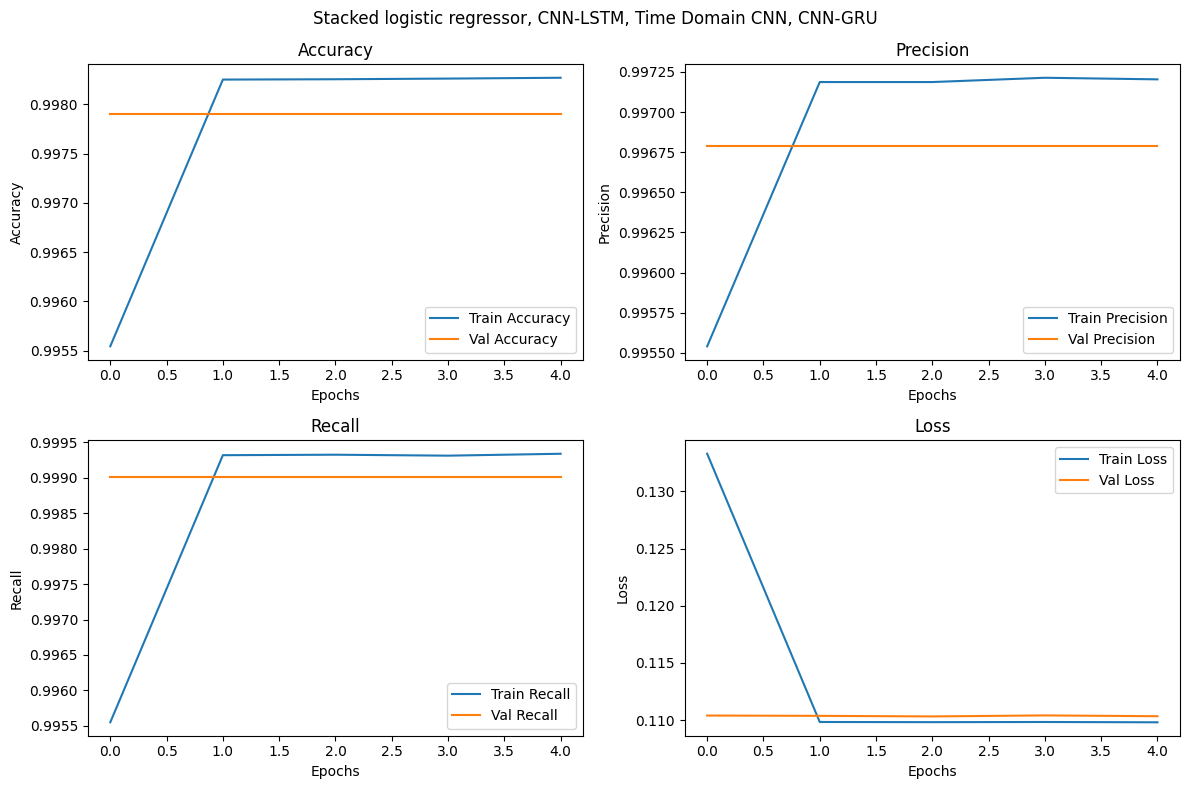

In [141]:
# creating sequences of length 1 from balanced dataset
train_bin_seq_ds = data_utils.create_binary_sequential_dataset(train_bal_files, filter_out_normal=False, seq_length=1, seq_shift=1)
val_bin_seq_ds = data_utils.create_binary_sequential_dataset(val_bal_files, filter_out_normal=False, seq_length=1, seq_shift=1)

history = bin_stacked_dnn_classifier2.fit(
    train_bin_seq_ds,
    validation_data = val_bin_seq_ds,
    epochs = metaclassifier_epochs,
)

plot_model_history(history.history, 'Stacked logistic regressor, CNN-LSTM, Time Domain CNN, CNN-GRU')

726/726 ━━━━━━━━━━━━━━━━━━━━ 33s 35ms/step
Accuracy: 99.050%
Precision: 91.963%
Recall: 99.857%
F1 : 0.9575
Kappa: 0.9521


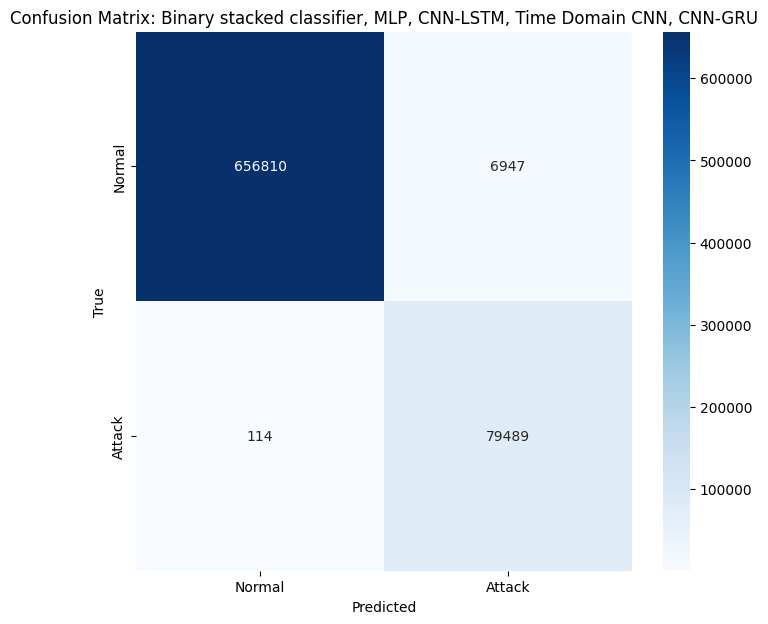

(0.9905012376237624,
 0.9196283955759175,
 0.9985678931698554,
 0.9574738465059414,
 0.9521375532147963)

In [142]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_stacked_dnn_classifier2.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, MLP, CNN-LSTM, Time Domain CNN, CNN-GRU')

| Model                      | Accuracy | Precision | Recall  | F1       | Kappa   |
|----------------------------|----------|-----------|---------|----------|---------|
| CNN-LSTM                   | 98.221%  | 90.863%   | 92.601% | 0.9172   | 0.9072  |
| CNN-GRU                    | 98.211%  | 92.830%   | 99.845% | 0.9621   | 0.9574  |
| Time Domain CNN            | 98.652%  | 92.117%   | 95.591% | 0.9382   | 0.9307  |
| Arithmetic mean            | 98.256%  | 91.973%   | 91.723% | 0.9185   | 0.9087  |
| Improvement from best      | -0.396%  | -0.857%   | -8.122% | -0.0436  | -0.0487 |
| F1 weighted mean           | 98.369%  | 92.346%   | 92.427% | 0.9239   | 0.9147  |
| Improvement from best      | -0.283%  | -0.484%   | -7.418% | -0.0382  | -0.0427 |
| Kappa weighted             | 98.345%  | 92.272%   | 92.277% | 0.9227   | 0.9135  | 
| Imor

kappa

Accuracy: 98.345%
Precision: 92.272%
Recall: 92.277%
F1 : 0.9227
Kappa: 0.9135

log reg

Accuracy: 99.038%
Precision: 91.870%
Recall: 99.857%
F1 : 0.9570
Kappa: 0.9516

weigh reg

Accuracy: 99.039%
Precision: 91.876%
Recall: 99.857%
F1 : 0.9570
Kappa: 0.9516

MLP

Accuracy: 99.050%
Precision: 91.963%
Recall: 99.857%
F1 : 0.9575
Kappa: 0.9521


In [5]:
import multiclass_cnn_lstm
import data_utils

mul_cnn_lstm_model = multiclass_cnn_lstm.multiclass_CNN_LSTM_model()

if not mul_cnn_lstm_model.built:
    dataset_lambda = lambda x: data_utils.create_multiclass_sequential_dataset(x)
    histories = data_utils.step_training(
        train_seq_files,
        val_seq_files,
        mul_cnn_lstm_model,
        dataset_lambda,
        epochs_per_step=4,
        training_callbacks=[multiclass_cnn_lstm.checkpoint_callback],
        n_initial_files = 5,
        increment = 0.5
        
    )
    history = defaultdict(list)
    for h in histories:
        for metric, values in h.items():
            history[metric].extend(values) 
    
    plot_model_history(history, "Multiclass CNN-LSTM")
    print(history)
    #loading best checkpoint
    mul_cnn_lstm_model = multiclass_cnn_lstm.multiclass_CNN_LSTM_model()
    
mul_cnn_lstm_model.name = 'mul_CNN-LSTM'    
mul_cnn_lstm_model.summary()


Model loaded from saved_models/multiclass_cnn_lstm.keras


Model: "mul_CNN-LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, None, 128)      │        25,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 128)      │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, None, 128)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, None, 64)       │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, None, 64)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, None, 32)       │         2,080 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, None, 32)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, None, 3)        │            99 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 624,779 (2.38 MB)

 Trainable params: 208,259 (813.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 416,520 (1.59 MB)

c:\Users\filip\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


242/242 ━━━━━━━━━━━━━━━━━━━━ 226s 934ms/step
Accuracy: 96.871%
Precision: 95.620%
Recall: 96.871%
F1 : 0.9600
Kappa: 0.7721


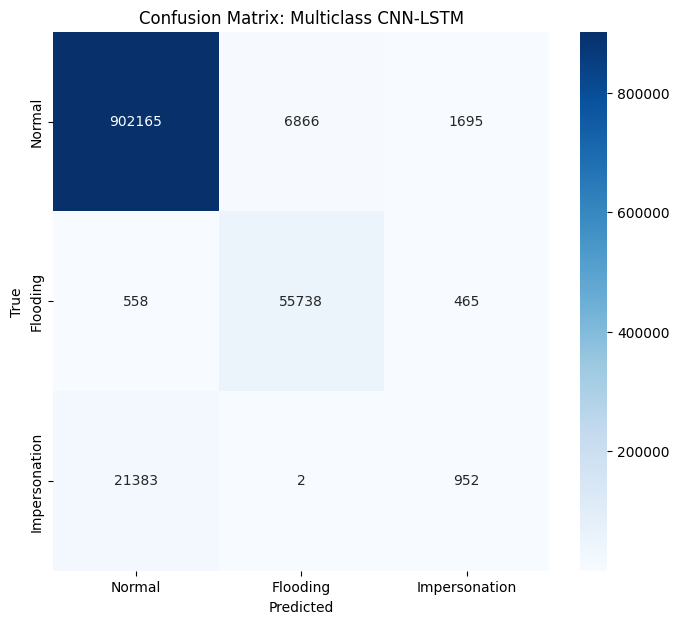

In [6]:
multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in multiclass_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)
y_pred = mul_cnn_lstm_model.predict(features)
y_pred = tf.argmax(y_pred, axis=2).numpy().flatten()
y_true = tf.argmax(labels, axis=2).numpy().flatten()
    
mul_cnn_lstm_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass CNN-LSTM", binary=False, average='weighted')


In [7]:
import multiclass_cnn_gru_lite
import data_utils

mul_cnn_gru_model = multiclass_cnn_gru_lite.multiclass_CNN_GRU_lite_model()

if not mul_cnn_gru_model.built:
    dataset_lambda = lambda x: data_utils.create_multiclass_sequential_dataset(x)
    histories = data_utils.step_training(
        train_seq_files,
        val_seq_files,
        mul_cnn_gru_model,
        dataset_lambda,
        epochs_per_step=4,
        training_callbacks=[multiclass_cnn_gru_lite.checkpoint_callback],
        n_initial_files = 5,
        increment = 0.5
        
    )
    history = defaultdict(list)
    for h in histories:
        for metric, values in h.items():
            history[metric].extend(values) 
    
    plot_model_history(history, "Multiclass CNN-GRU")
    print(history)
    #loading best checkpoint
    mul_cnn_gru_model = multiclass_cnn_gru_lite.multiclass_CNN_GRU_lite_model()
    
mul_cnn_gru_model.name = 'mul_CNN-GRU'    
mul_cnn_gru_model.summary()


Model loaded from saved_models/multiclass_cnn_gru_lite.keras


Model: "mul_CNN-GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, None, 40)       │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 40)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, None, 32)       │         7,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, None, 3)        │            99 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,411 (103.17 KB)

 Trainable params: 8,803 (34.39 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,608 (68.79 KB)

c:\Users\filip\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


242/242 ━━━━━━━━━━━━━━━━━━━━ 147s 606ms/step
Accuracy: 97.392%
Precision: 97.509%
Recall: 97.392%
F1 : 0.9691
Kappa: 0.8163


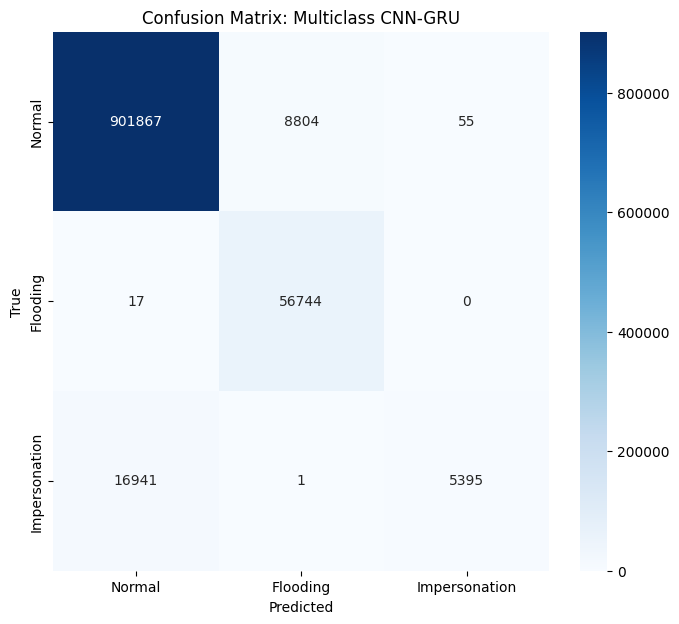

In [8]:
multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in multiclass_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)
y_pred = mul_cnn_gru_model.predict(features)
y_pred = tf.argmax(y_pred, axis=2).numpy().flatten()
y_true = tf.argmax(labels, axis=2).numpy().flatten()
    
mul_cnn_gru_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass CNN-GRU", binary=False, average='weighted')


In [34]:
import multiclass_td_cnn
import data_utils

mul_td_cnn_model = multiclass_td_cnn.multiclass_time_domain_CNN_model()

if not mul_td_cnn_model.built:
    dataset_lambda = lambda x: data_utils.create_multiclass_sequential_dataset(x)
    histories = data_utils.step_training(
        train_seq_files,
        val_seq_files,
        mul_td_cnn_model,
        dataset_lambda,
        epochs_per_step=4,
        training_callbacks=[multiclass_td_cnn.checkpoint_callback],
        n_initial_files = 5,
        increment = 0.5
        
    )
    history = defaultdict(list)
    for h in histories:
        for metric, values in h.items():
            history[metric].extend(values) 
    
    plot_model_history(history, "Multiclass Time-Domain CNN")
    print(history)
    #loading best checkpoint
    mul_td_cnn_model = multiclass_td_cnn.multiclass_time_domain_CNN_model()
    
    
mul_td_cnn_model.summary()


Model loaded from saved_models/multiclass_td_cnn.keras


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, None, 128)      │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, None, 64)       │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, None, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, None, 32)       │        10,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, None, 32)       │         1,056 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, None, 3)        │            99 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,563 (482.67 KB)

 Trainable params: 41,187 (160.89 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 82,376 (321.79 KB)

c:\Users\filip\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


242/242 ━━━━━━━━━━━━━━━━━━━━ 60s 249ms/step
Accuracy: 99.608%
Precision: 99.607%
Recall: 99.608%
F1 : 0.9960
Kappa: 0.9734


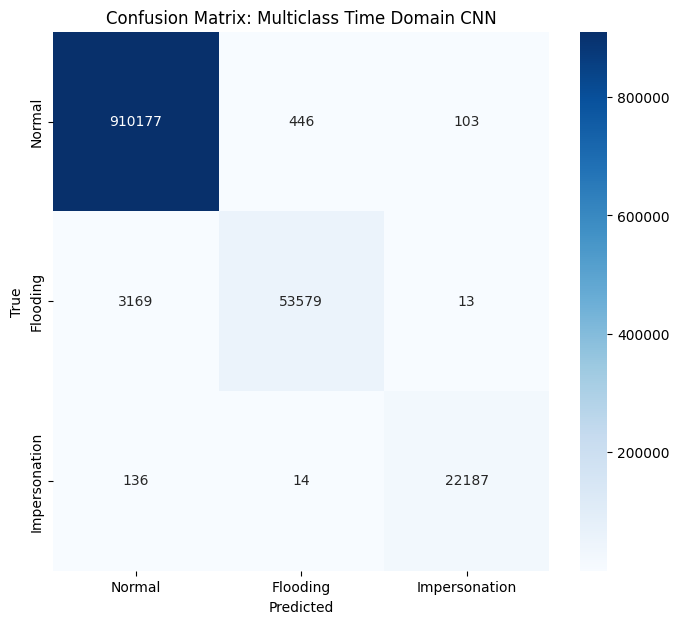

In [35]:
multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in multiclass_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)
y_pred = mul_td_cnn_model.predict(features)
y_pred = tf.argmax(y_pred, axis=2).numpy().flatten()
y_true = tf.argmax(labels, axis=2).numpy().flatten()
    
mul_td_cnn_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass Time Domain CNN", binary=False, average='weighted')


In [10]:
import multiclass_cnn1d
import data_utils

mul_cnn1d_model = multiclass_cnn1d.multiclass_CNN1D_model()

if not mul_cnn1d_model.built:
    mul_bal_train_ds = data_utils.create_binary_dataset(train_bal_files)
    mul_bal_val_ds = data_utils.create_binary_dataset(val_bal_files)
    history = mul_cnn1d_model.fit(
            mul_bal_train_ds,
            validation_data = mul_bal_val_ds,
            epochs=30,
            callbacks = [multiclass_cnn1d.checkpoint_callback],
        )
    
    plot_model_history(history.history, 'Multiclass 1D-CNN')

mul_cnn1d_model.summary()



Model loaded from saved_models/multiclass_cnn1d.keras


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 1, 39)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1, 256)         │        10,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1, 128)         │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 1, 64)          │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │         6,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 174,587 (681.98 KB)

 Trainable params: 58,195 (227.32 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 116,392 (454.66 KB)

c:\Users\filip\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


28548/28548 ━━━━━━━━━━━━━━━━━━━━ 255s 9ms/step
Accuracy: 98.674%
Precision: 98.798%
Recall: 98.674%
F1 : 0.9871
Kappa: 0.9279


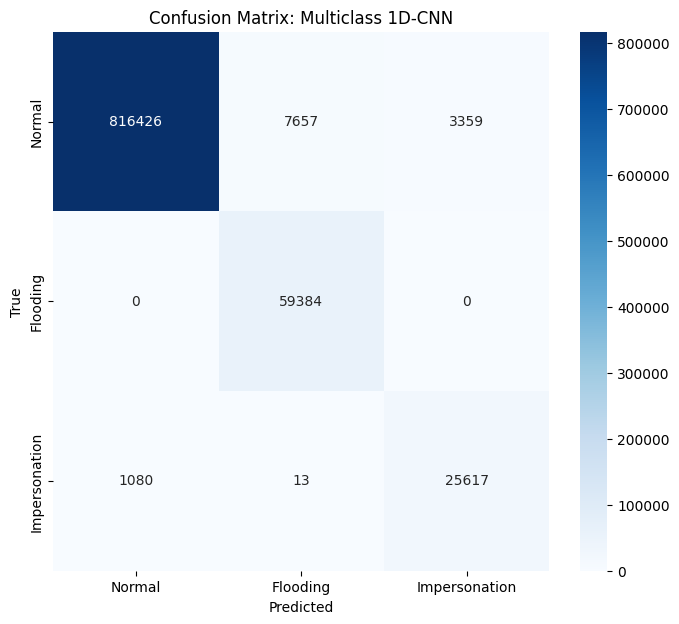

In [11]:
multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files, batch=False)
features = []
labels = []

for x, y in multiclass_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)
y_pred = mul_cnn1d_model.predict(features)
y_pred = tf.argmax(y_pred, axis=1).numpy().flatten()
y_true = tf.argmax(labels, axis=1).numpy().flatten()
    
mul_cnn1d_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass 1D-CNN", binary=False, average='weighted')


In [12]:
import multiclass_dnn
import data_utils

mul_dnn_model = multiclass_dnn.multiclass_DNN_model()

if not mul_dnn_model.built:
    mul_bal_train_ds = data_utils.create_binary_dataset(train_bal_files)
    mul_bal_val_ds = data_utils.create_binary_dataset(val_bal_files)
    history = mul_dnn_model.fit(
            mul_bal_train_ds,
            validation_data = mul_bal_val_ds,
            epochs=30,
            callbacks = [multiclass_dnn.checkpoint_callback],
        )
    
    plot_model_history(history.history, 'Multiclass MLP')

mul_dnn_model.summary()



Model loaded from saved_models/multiclass_dnn.keras


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 60)             │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 60)             │           240 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 40)             │         2,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 40)             │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 24)             │           792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24)             │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 12)             │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12)             │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            39 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,576 (60.85 KB)

 Trainable params: 7,619 (29.76 KB)

 Non-trainable params: 336 (1.31 KB)

 Optimizer params: 7,621 (29.77 KB)

c:\Users\filip\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


28548/28548 ━━━━━━━━━━━━━━━━━━━━ 346s 12ms/step
Accuracy: 98.193%
Precision: 98.295%
Recall: 98.193%
F1 : 0.9822
Kappa: 0.9007


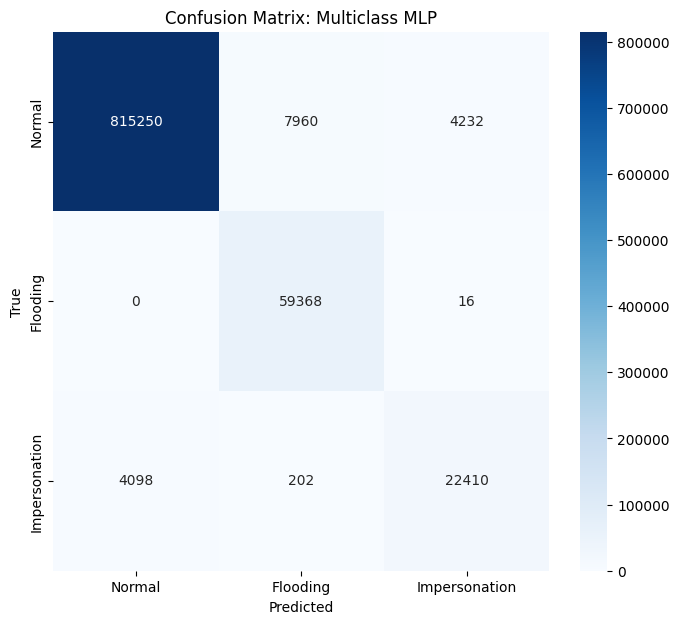

In [13]:
multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files, batch=False)
features = []
labels = []

for x, y in multiclass_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)
y_pred = mul_dnn_model.predict(features)
y_pred = tf.argmax(y_pred, axis=1).numpy().flatten()
y_true = tf.argmax(labels, axis=1).numpy().flatten()
    
mul_dnn_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass MLP", binary=False, average='weighted')


### Results

* CNN-LSTM
    * Accuracy: 96.236%
    * Precision: 94.644%
    * Recall: 96.236%
    * F1 : 0.9502
    * Kappa: 0.7867
* CNN-GRU
    * Accuracy: 96.920%
    * Precision: 97.016%
    * Recall: 96.920%
    * F1 : 0.9622
    * Kappa: 0.8308
* Time Domain CNN
    * Accuracy: 81.091%
    * Precision: 95.902%
    * Recall: 81.091%
    * F1 : 0.8650
    * Kappa: 0.4669
* 1D-CNN
    * Accuracy: 98.251%
    * Precision: 87.142%
    * Recall: 98.098%
    * F1 : 0.9230
    * Kappa: 0.9155
* MLP
    * Accuracy: 97.178%
    * Precision: 81.124%
    * Recall: 92.141%
    * F1 : 0.8628
    * Kappa: 0.8639

In [17]:
from keras.layers import Input, Dense, TimeDistributed, Concatenate, Average

input_shape = (None, n_features)
input = Input(input_shape)

td_mul_cnn1d_model = TimeDistributed(mul_cnn1d_model)

mul_base_classifiers = [
    mul_cnn_lstm_model,
    mul_cnn_gru_model,
    td_mul_cnn1d_model,
]

# disabling training of base classifiers
for bc in mul_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in mul_base_classifiers]
#combined_output = Concatenate(axis=-2)(base_classifiers_outputs)


y = Average()(base_classifiers_outputs)

mul_arithmetic_mean_aggregate1 = tf.keras.Model(input, y)

metaclassifier_epochs = 3

mul_arithmetic_mean_aggregate1.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

mul_arithmetic_mean_aggregate1.summary()

Model: "functional_49"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mul_CNN-LSTM        │ (None, None, 3)   │    208,259 │ input_layer_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mul_CNN-GRU         │ (None, None, 3)   │      8,803 │ input_layer_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, None, 3)   │     58,195 │ input_layer_1[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average (Average)   │ (None, None, 3)   │          0 │ mul_CNN-LSTM[0][… │
│                     │                   │            │ mul_CNN-GRU[0][0… │
│                     │                   │            │ time_distributed… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 275,257 (1.05 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 275,257 (1.05 MB)

c:\Users\filip\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


242/242 ━━━━━━━━━━━━━━━━━━━━ 685s 3s/step
(989824,) (989824,)
Accuracy: 97.101%
Precision: 96.774%
Recall: 97.101%
F1 : 0.9652
Kappa: 0.7957


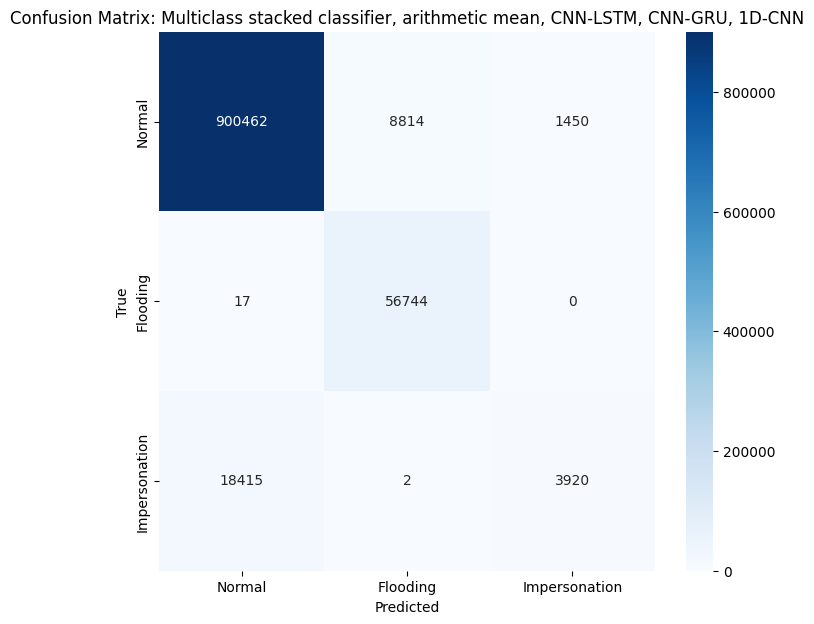

In [18]:
multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in multiclass_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)
y_pred = mul_arithmetic_mean_aggregate1.predict(features)
y_pred = tf.argmax(y_pred, axis=2).numpy().flatten()
y_true = tf.argmax(labels, axis=2).numpy().flatten()
print(y_pred.shape, y_true.shape)
    
mul_arithmetic_mean_aggregate1_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass stacked classifier, arithmetic mean, CNN-LSTM, CNN-GRU, 1D-CNN", binary=False, average='weighted')

In [24]:
import math
from keras.layers import Input, Dense, TimeDistributed, Lambda

input_shape = (None, n_features)
input = Input(input_shape)

td_mul_cnn1d_model = TimeDistributed(mul_cnn1d_model)

mul_base_classifiers = [
    mul_cnn_lstm_model,
    mul_cnn_gru_model,
    td_mul_cnn1d_model,
]

mul_f1_weights = [
    mul_cnn_lstm_metrics[3],
    mul_cnn_gru_metrics[3],
    mul_cnn1d_metrics[3],
]

mul_f1_weights = [math.log(w / (1 - w)) for w in mul_f1_weights]

sum_mul_f1_weights = sum(mul_f1_weights)

mul_f1_weights = tf.constant([w / sum_mul_f1_weights for w in mul_f1_weights], dtype=tf.float32, shape=(len(mul_f1_weights), 1))

print('F1 calculated_weights')
print(mul_f1_weights.numpy())

# disabling training of base classifiers
for bc in mul_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in mul_base_classifiers]

y = Lambda(lambda x: tf.stack(x, axis = -1))(base_classifiers_outputs)
y = Lambda(lambda x: tf.multiply(x, mul_f1_weights), output_shape=(None, 3))(y)
y = Lambda(lambda x: tf.reduce_sum(x, axis =-1), output_shape=(None, 3))(y)

mul_f1_weighted_aggregate1 = tf.keras.Model(input, y)

metaclassifier_epochs = 3

mul_f1_weighted_aggregate1.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

mul_f1_weighted_aggregate1.summary()

F1 calculated_weights
[[0.29906663]
 [0.32407725]
 [0.37685612]]



Model: "functional_50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mul_CNN-LSTM        │ (None, None, 3)   │    208,259 │ input_layer_6[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mul_CNN-GRU         │ (None, None, 3)   │      8,803 │ input_layer_6[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_6  │ (None, None, 3)   │     58,195 │ input_layer_6[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, None, 3,   │          0 │ mul_CNN-LSTM[3][… │
│                     │ 3)                │            │ mul_CNN-GRU[3][0… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, None, 3)   │          0 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, None, 3)   │          0 │ lambda_1[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 275,257 (1.05 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 275,257 (1.05 MB)

c:\Users\filip\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


242/242 ━━━━━━━━━━━━━━━━━━━━ 652s 3s/step
Accuracy: 97.111%
Precision: 96.771%
Recall: 97.111%
F1 : 0.9658
Kappa: 0.7973


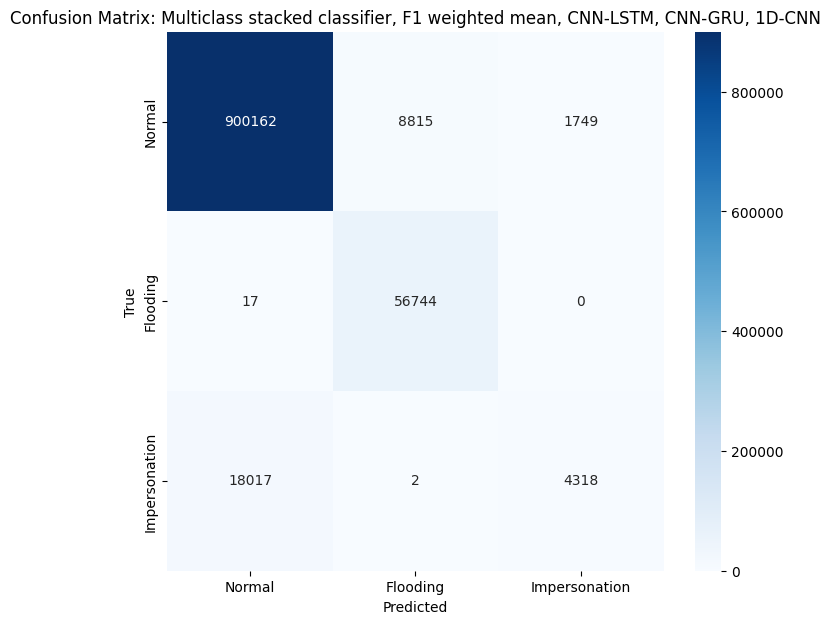

In [25]:
multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in multiclass_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)
y_pred = mul_f1_weighted_aggregate1.predict(features)
y_pred = tf.argmax(y_pred, axis=2).numpy().flatten()
y_true = tf.argmax(labels, axis=2).numpy().flatten()
    
mul_f1_weighted_aggregate1_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass stacked classifier, F1 weighted mean, CNN-LSTM, CNN-GRU, 1D-CNN", binary=False, average='weighted')

In [26]:
from keras.layers import Input, Dense, TimeDistributed, Concatenate, Reshape

input_shape = (None, n_features)
input = Input(input_shape)

td_mul_cnn1d_model = TimeDistributed(mul_cnn1d_model)

mul_base_classifiers = [
    mul_cnn_lstm_model,
    mul_cnn_gru_model,
    td_mul_cnn1d_model,
]

mul_kappa_weights = [
    mul_cnn_lstm_metrics[4],
    mul_cnn_gru_metrics[4],
    mul_cnn1d_metrics[4],
]

mul_kappa_weights = [math.log(w / (1 - w)) for w in mul_kappa_weights]

sum_mul_kappa_weights = sum(mul_kappa_weights)

mul_kappa_weights = tf.constant([w / sum_mul_kappa_weights for w in mul_kappa_weights], dtype=tf.float32,  shape=(len(mul_kappa_weights), 1))

print('Cohe Kappa calculated_weights')
print(mul_kappa_weights.numpy())

# disabling training of base classifiers
for bc in mul_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in mul_base_classifiers]

y = Lambda(lambda x: tf.stack(x, axis = -1))(base_classifiers_outputs)
y = Lambda(lambda x: tf.multiply(x, mul_kappa_weights), output_shape=(None, 3))(y)
y = Lambda(lambda x: tf.reduce_sum(x, axis =-1), output_shape=(None, 3))(y)

mul_kappa_weighted_aggregate1 = tf.keras.Model(input, y)

metaclassifier_epochs = 3

mul_kappa_weighted_aggregate1.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

mul_kappa_weighted_aggregate1.summary()

Cohe Kappa calculated_weights
[[0.25631112]
 [0.31324986]
 [0.43043903]]


Model: "functional_51"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mul_CNN-LSTM        │ (None, None, 3)   │    208,259 │ input_layer_7[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mul_CNN-GRU         │ (None, None, 3)   │      8,803 │ input_layer_7[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_7  │ (None, None, 3)   │     58,195 │ input_layer_7[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, None, 3,   │          0 │ mul_CNN-LSTM[4][… │
│                     │ 3)                │            │ mul_CNN-GRU[4][0… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, None, 3)   │          0 │ lambda_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_5 (Lambda)   │ (None, None, 3)   │          0 │ lambda_4[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 275,257 (1.05 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 275,257 (1.05 MB)

c:\Users\filip\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


242/242 ━━━━━━━━━━━━━━━━━━━━ 671s 3s/step
Accuracy: 97.121%
Precision: 96.770%
Recall: 97.121%
F1 : 0.9667
Kappa: 0.7999


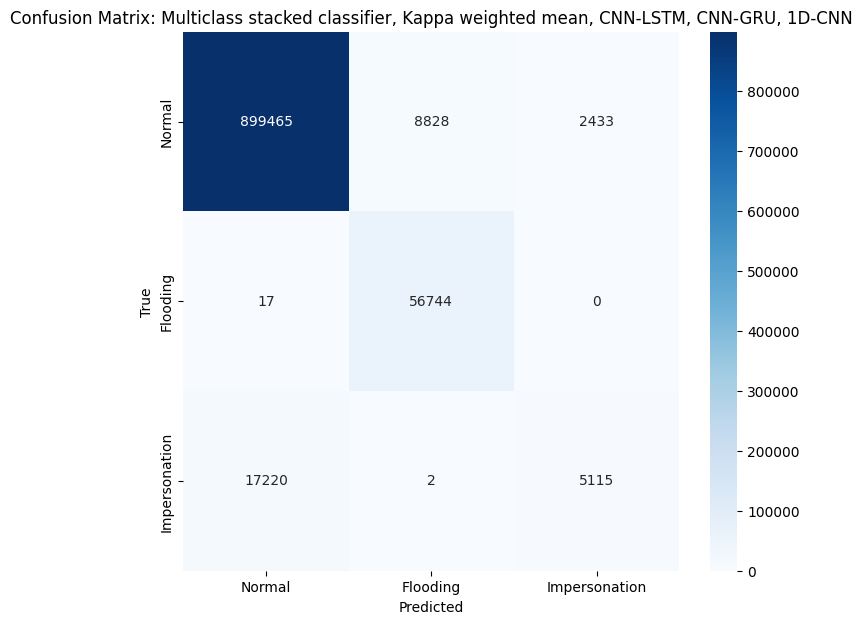

In [27]:
multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in multiclass_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)
y_pred = mul_kappa_weighted_aggregate1.predict(features)
y_pred = tf.argmax(y_pred, axis=2).numpy().flatten()
y_true = tf.argmax(labels, axis=2).numpy().flatten()
    
mul_kappa_weighted_aggregate1_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass stacked classifier, Kappa weighted mean, CNN-LSTM, CNN-GRU, 1D-CNN", binary=False, average='weighted')

In [28]:
from keras.layers import Input, Dense, TimeDistributed, Concatenate, Reshape, Dense

input_shape = (None, n_features)
input = Input(input_shape)

td_mul_cnn1d_model = TimeDistributed(mul_cnn1d_model)

mul_base_classifiers = [
    mul_cnn_lstm_model,
    mul_cnn_gru_model,
    td_mul_cnn1d_model,
]

# disabling training of base classifiers
for bc in mul_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in mul_base_classifiers]

y = Lambda(lambda x: tf.concat(x, axis=-1))(base_classifiers_outputs)
y = TimeDistributed(Dense(3, activation='softmax'))(y)

mul_softmax_regression1 = tf.keras.Model(input, y)

metaclassifier_epochs = 1

mul_softmax_regression1.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

mul_softmax_regression1.summary()

Model: "functional_52"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mul_CNN-LSTM        │ (None, None, 3)   │    208,259 │ input_layer_8[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mul_CNN-GRU         │ (None, None, 3)   │      8,803 │ input_layer_8[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_8  │ (None, None, 3)   │     58,195 │ input_layer_8[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_6 (Lambda)   │ (None, None, 9)   │          0 │ mul_CNN-LSTM[5][… │
│                     │                   │            │ mul_CNN-GRU[5][0… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_9  │ (None, None, 3)   │         30 │ lambda_6[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 275,287 (1.05 MB)

 Trainable params: 30 (120.00 B)

 Non-trainable params: 275,257 (1.05 MB)

c:\Users\filip\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


  18625/Unknown 2919s 157ms/step - accuracy: 0.9367 - loss: 0.2001 - precision: 0.9538 - recall: 0.9146

c:\Users\filip\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


18625/18625 ━━━━━━━━━━━━━━━━━━━━ 3329s 179ms/step - accuracy: 0.9367 - loss: 0.2001 - precision: 0.9538 - recall: 0.9146 - val_accuracy: 0.9800 - val_loss: 0.0739 - val_precision: 0.9800 - val_recall: 0.9800


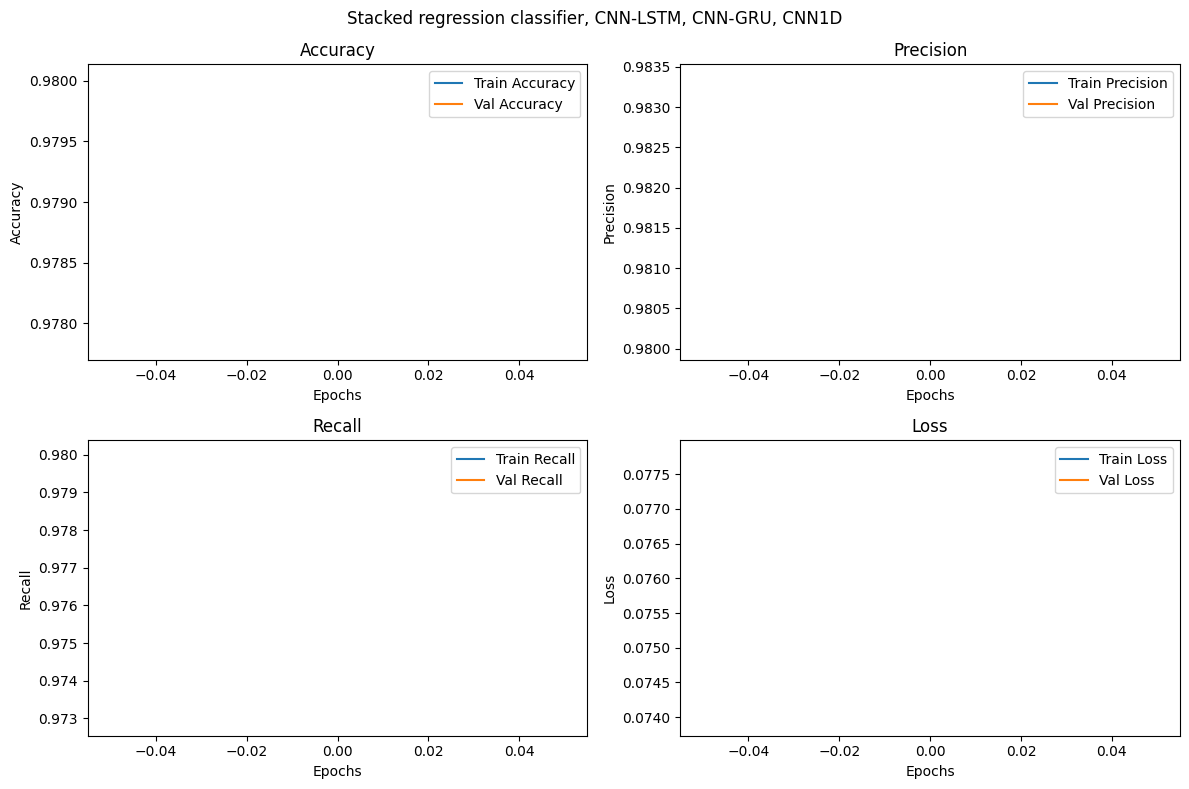

In [29]:
train_mul_seq_ds = data_utils.create_multiclass_sequential_dataset(train_bal_files, filter_out_normal=False, seq_length=1, seq_shift=1)
val_mul_seq_ds = data_utils.create_multiclass_sequential_dataset(val_bal_files, filter_out_normal=False, seq_length=1, seq_shift=1)

history = mul_softmax_regression1.fit(
    train_mul_seq_ds,
    validation_data = val_mul_seq_ds,
    epochs = metaclassifier_epochs
)

plot_model_history(history.history, 'Stacked regression classifier, CNN-LSTM, CNN-GRU, CNN1D')

242/242 ━━━━━━━━━━━━━━━━━━━━ 5265s 22s/step
Accuracy: 98.503%
Precision: 98.690%
Recall: 98.503%
F1 : 0.9855
Kappa: 0.9068


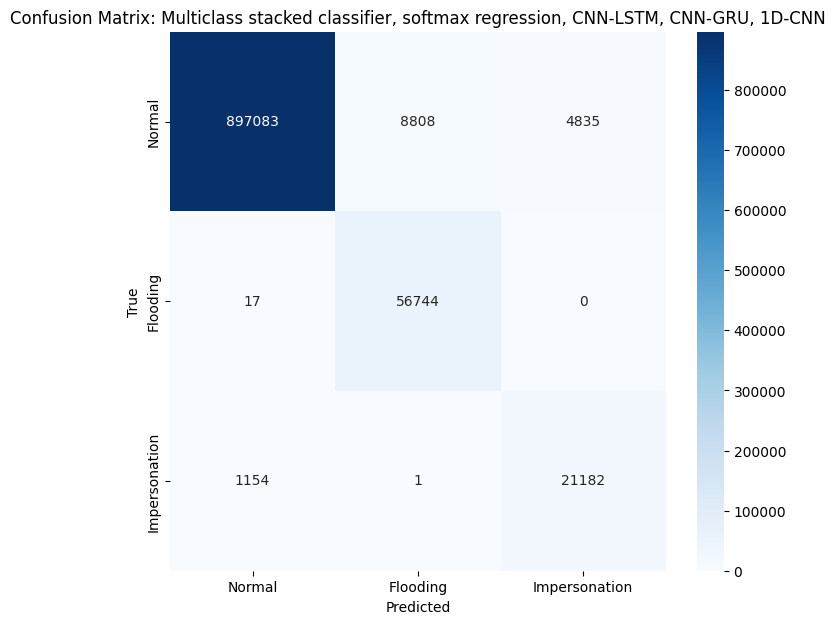

In [30]:
multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in multiclass_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)
y_pred = mul_softmax_regression1.predict(features)
y_pred = tf.argmax(y_pred, axis=2).numpy().flatten()
y_true = tf.argmax(labels, axis=2).numpy().flatten()
    
mul_softmax_regression1_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass stacked classifier, softmax regression, CNN-LSTM, CNN-GRU, 1D-CNN", binary=False, average='weighted')

In [31]:
from keras.layers import Input, Dense, TimeDistributed, Concatenate, Reshape, Dense

input_shape = (None, n_features)
input = Input(input_shape)

td_mul_cnn1d_model = TimeDistributed(mul_cnn1d_model)

mul_base_classifiers = [
    mul_cnn_lstm_model,
    mul_cnn_gru_model,
    td_mul_cnn1d_model,
]

# disabling training of base classifiers
for bc in mul_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in mul_base_classifiers]

y = Lambda(lambda x: tf.concat(x, axis=-1))(base_classifiers_outputs)
y = TimeDistributed(Dense(16, activation='relu'))(y)
y = TimeDistributed(Dense(8, activation='relu'))(y)
y = TimeDistributed(Dense(3, activation='softmax'))(y)

mul_dnn_classifier1 = tf.keras.Model(input, y)

metaclassifier_epochs = 1

mul_dnn_classifier1.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

mul_dnn_classifier1.summary()

Model: "functional_53"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mul_CNN-LSTM        │ (None, None, 3)   │    208,259 │ input_layer_9[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mul_CNN-GRU         │ (None, None, 3)   │      8,803 │ input_layer_9[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_10 │ (None, None, 3)   │     58,195 │ input_layer_9[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_7 (Lambda)   │ (None, None, 9)   │          0 │ mul_CNN-LSTM[6][… │
│                     │                   │            │ mul_CNN-GRU[6][0… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_11 │ (None, None, 16)  │        160 │ lambda_7[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_12 │ (None, None, 8)   │        136 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_13 │ (None, None, 3)   │         27 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 275,580 (1.05 MB)

 Trainable params: 323 (1.26 KB)

 Non-trainable params: 275,257 (1.05 MB)

c:\Users\filip\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


  18625/Unknown 5174s 278ms/step - accuracy: 0.9768 - loss: 0.0784 - precision: 0.9865 - recall: 0.9553

c:\Users\filip\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


18625/18625 ━━━━━━━━━━━━━━━━━━━━ 5593s 300ms/step - accuracy: 0.9768 - loss: 0.0784 - precision: 0.9865 - recall: 0.9553 - val_accuracy: 0.9786 - val_loss: 0.0762 - val_precision: 0.9786 - val_recall: 0.9785


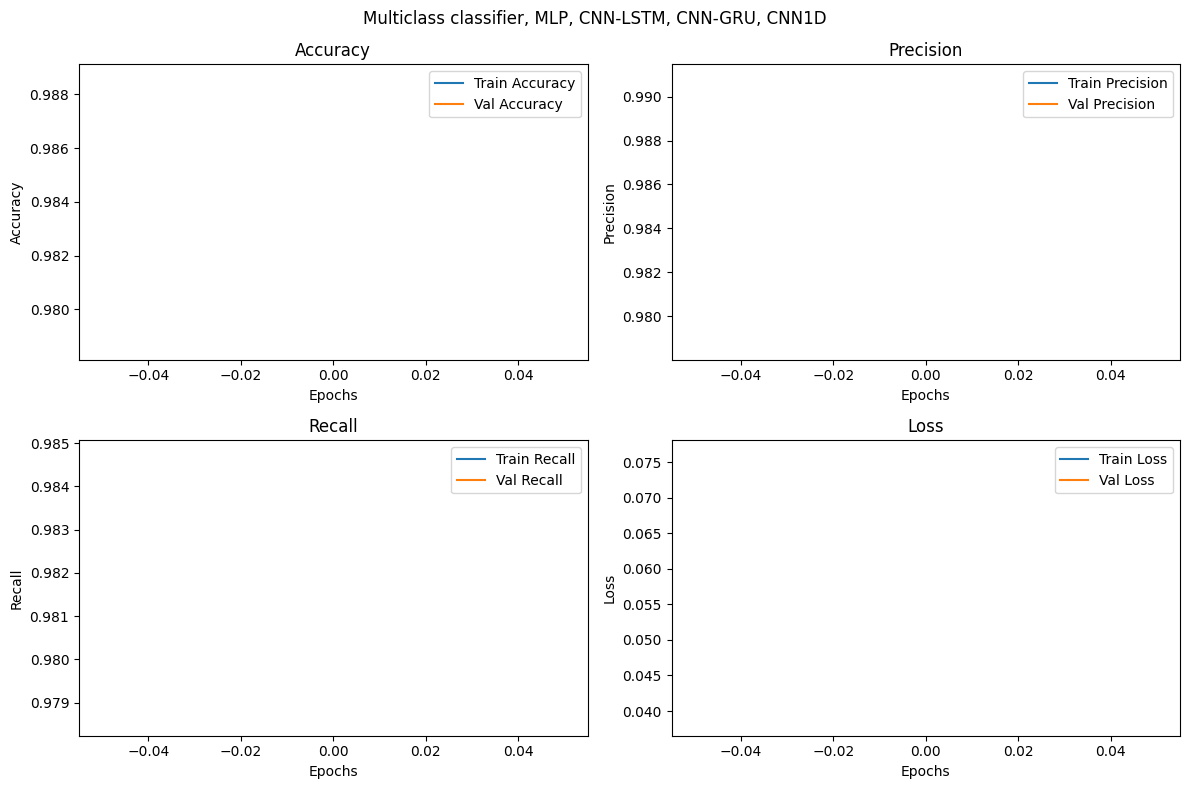

In [32]:
train_mul_seq_ds = data_utils.create_multiclass_sequential_dataset(train_bal_files, filter_out_normal=False, seq_length=1, seq_shift=1)
val_mul_seq_ds = data_utils.create_multiclass_sequential_dataset(val_bal_files, filter_out_normal=False, seq_length=1, seq_shift=1)

history = mul_dnn_classifier1.fit(
    train_mul_seq_ds,
    validation_data = val_mul_seq_ds,
    epochs = metaclassifier_epochs
)

plot_model_history(history.history, 'Multiclass classifier, MLP, CNN-LSTM, CNN-GRU, CNN1D')

242/242 ━━━━━━━━━━━━━━━━━━━━ 703s 3s/step
Accuracy: 98.564%
Precision: 98.711%
Recall: 98.564%
F1 : 0.9860
Kappa: 0.9097


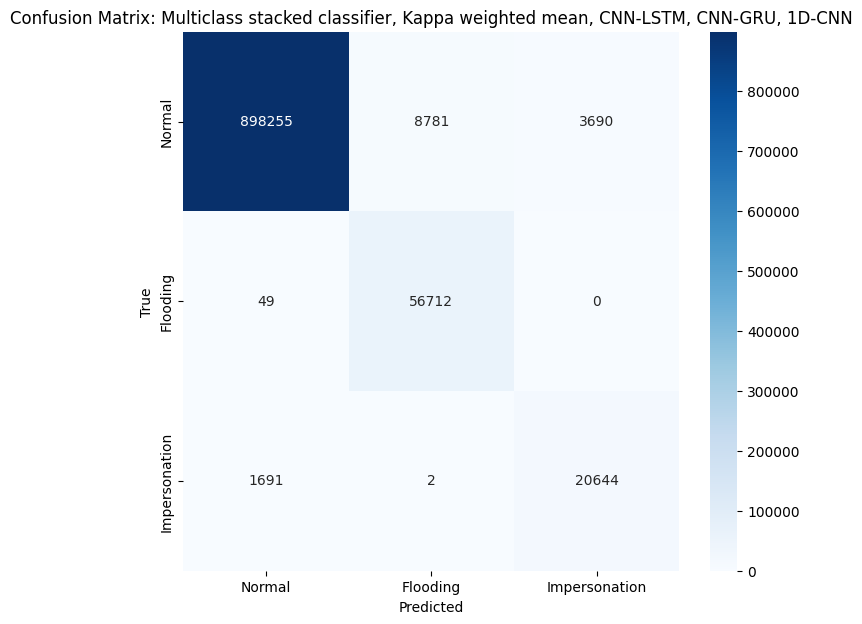

In [33]:
multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in multiclass_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)
y_pred = mul_dnn_classifier1.predict(features)
y_pred = tf.argmax(y_pred, axis=2).numpy().flatten()
y_true = tf.argmax(labels, axis=2).numpy().flatten()
    
mul_dnn_classifier1_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass stacked classifier, Kappa weighted mean, CNN-LSTM, CNN-GRU, 1D-CNN", binary=False, average='weighted')

|                     | Accuarcy | Precision | Recall  | F1      | Kappa   |
|---------------------|----------|-----------|---------|---------|---------|
| CNN-LSTM            | 96,871%  | 95,620%   | 96,871% | 0,9600  | 0,7721  |
| CNN-GRU             | 97,392%  | 97,509%   | 97,392% | 0,9691  | 0,8163  |
| 1D-CNN              | 98,140%  | 98,411%   | 98,140% | 0,9821  | 0,8859  |
| Best                | 98,140%  | 98,411%   | 98,140% | 0,9821  | 0,8859  |
| Arithmetic mean     | 97,101%  | 96,774%   | 97,101% | 0,9652  | 0,7957  |
| Improvement         | -1,039%  | -1,637%   | -1,039% | -0,0169 | -0,0902 |
| F1 weighted mean    | 97,111%  | 96,771%   | 97,111% | 0,9658  | 0,7973  |
| Improvement         | -1,029%  | -1,640%   | -1,029% | -0,0163 | -0,0886 |
| Kappa weighted mean | 97,121%  | 96,77%    | 97,121  | 0,9667  | 0,7999  |
| Improvement         | -1,019%  | -1,641    |-1,019   | -0,0154 | -0,086  |
| Softmax regression  | 98,503%  | 98,690%   | 98,503% | 0,9855  | 0,9068  |
| Improvement         |  0,363%  | 0,279%    | 0,363%  | 0,0034  | 0,0209  |
| MLP                 | 98,564%  | 98,711%   | 98,564% | 0,9860	 | 0,9097  |
| Improvement         |  0,424%  |  0,300%   |  0,424% | 0,0039  | 0,0238  |